Modelle vergleichen über CV

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.width", 200)

# Führt CV durch und berechnet die Metriken
def repeated_k_fold(model, X, y, n_splits=5, n_repeats=10):
    rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

    accuracy_train, accuracy_test = [], []
    f1, recall, roc_auc = [], [], []

    for train_index, test_index in rkf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        accuracy_train.append(accuracy_score(y_train, y_train_pred))
        accuracy_test.append(accuracy_score(y_test, y_test_pred))
        f1.append(f1_score(y_test, y_test_pred))
        recall.append(recall_score(y_test, y_test_pred))
        roc_auc.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

    return {
        "Train Accuracy": (np.mean(accuracy_train), np.std(accuracy_train)),
        "Test Accuracy": (np.mean(accuracy_test), np.std(accuracy_test)),
        "F1-Score_1": (np.mean(f1), np.std(f1)),
        "Recall_1": (np.mean(recall), np.std(recall)),
        "ROC-AUC_1": (np.mean(roc_auc), np.std(roc_auc)),
    }


# Pfad zur Datei
file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML.xlsx"

try:
    df = pd.read_excel(file_path)

    # Zielvariable (y) und Features (X) extrahieren
    y = df['Verletzungsstatus']
    
    # Dummy-Variable "Geschlecht_weiblich" separieren
    if 'Geschlecht_weiblich' in df.columns:
        geschlecht_weiblich = df[['Geschlecht_weiblich']]
        X = df.drop(columns=['Verletzungsstatus', 'Geschlecht_weiblich'])
    else:
        X = df.drop(columns=['Verletzungsstatus'])
        geschlecht_weiblich = None  

    # Skalierung der Features (ohne "Geschlecht_weiblich")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Falls vorhanden, die Dummy-Variable wieder anhängen
    if geschlecht_weiblich is not None:
        X_scaled = np.hstack((X_scaled, geschlecht_weiblich.values))

    # Modelle definieren
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
        "LightGBM": LGBMClassifier(verbose=-1, random_state=42),
        "SVC": SVC(probability=True, random_state=42),
        "k-Nearest Neighbors": KNeighborsClassifier(),
        "MLP Classifier": MLPClassifier(max_iter=1000, random_state=42),
        "Gaussian Naive Bayes": GaussianNB(),
        "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
        "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
        "Bagging Classifier": BaggingClassifier(random_state=42),
        "Extra Trees": ExtraTreesClassifier(random_state=42),
    }

    results = []
    for model_name, model in models.items():
        print(f"Modell wird validiert: {model_name}")
        metrics = repeated_k_fold(model, X_scaled, y)  
        
        # Formatierung der Ergebnisse mit ±
        formatted_metrics = {
            "Model": model_name,
            "Train Accuracy": f"{metrics['Train Accuracy'][0]:.4f} ± {metrics['Train Accuracy'][1]:.4f}",
            "Test Accuracy": f"{metrics['Test Accuracy'][0]:.4f} ± {metrics['Test Accuracy'][1]:.4f}",
            "F1-Score_1": f"{metrics['F1-Score_1'][0]:.4f} ± {metrics['F1-Score_1'][1]:.4f}",
            "Recall_1": f"{metrics['Recall_1'][0]:.4f} ± {metrics['Recall_1'][1]:.4f}",
            "ROC-AUC_1": f"{metrics['ROC-AUC_1'][0]:.4f} ± {metrics['ROC-AUC_1'][1]:.4f}",
        }

        results.append(formatted_metrics)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="ROC-AUC_1", ascending=False)

    print("\nErgebnisse der Modelle:")
    print(results_df)


except FileNotFoundError:
    print("Die Datei wurde nicht gefunden. Bitte überprüfe den Pfad.")
except Exception as e:
    print(f"Ein Fehler ist aufgetreten: {e}")


Normalisierung innerhalb der CV (Datenleakage gänzlich vermeiden)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.width", 200)

def repeated_k_fold(model, X, y, n_splits=5, n_repeats=10):
    rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

    accuracy_train, accuracy_test = [], []
    f1, recall, roc_auc = [], [], []

    for train_index, test_index in rkf.split(X, y):
        # Aufteilen in Trainings- und Testdaten
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Skalierung: nur an den Trainingsdaten fitten
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model.fit(X_train_scaled, y_train)

        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        accuracy_train.append(accuracy_score(y_train, y_train_pred))
        accuracy_test.append(accuracy_score(y_test, y_test_pred))
        f1.append(f1_score(y_test, y_test_pred))
        recall.append(recall_score(y_test, y_test_pred))
        roc_auc.append(roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1]))

    return {
        "Train Accuracy": (np.mean(accuracy_train), np.std(accuracy_train)),
        "Test Accuracy": (np.mean(accuracy_test), np.std(accuracy_test)),
        "F1-Score_1": (np.mean(f1), np.std(f1)),
        "Recall_1": (np.mean(recall), np.std(recall)),
        "ROC-AUC_1": (np.mean(roc_auc), np.std(roc_auc)),
    }


# Pfad zur Datei
file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML_neu.xlsx"

try: 
    df = pd.read_excel(file_path)
    
    # Zielvariable (y) und Features (X) extrahieren
    y = df['Verletzungsstatus']
    
    # Dummy-Variable "Geschlecht_weiblich" separieren, falls vorhanden
    if 'Geschlecht_weiblich' in df.columns:
        geschlecht_weiblich = df[['Geschlecht_weiblich']]
        X = df.drop(columns=['Verletzungsstatus', 'Geschlecht_weiblich'])
        # Die Dummy-Variable wieder anhängen
        X = np.hstack((X.values, geschlecht_weiblich.values))
    else:
        X = df.drop(columns=['Verletzungsstatus']).values
    
    # Modelle definieren
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
        "LightGBM": LGBMClassifier(verbose=-1, random_state=42),
        "SVC": SVC(probability=True, random_state=42),
        "k-Nearest Neighbors": KNeighborsClassifier(),
        "MLP Classifier": MLPClassifier(max_iter=1000, random_state=42),
        "Gaussian Naive Bayes": GaussianNB(),
        "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
        "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
        "Bagging Classifier": BaggingClassifier(random_state=42),
        "Extra Trees": ExtraTreesClassifier(random_state=42),
    }
    
    results = []
    for model_name, model in models.items():
        print(f"Modell wird validiert: {model_name}")
        metrics = repeated_k_fold(model, X, y)
        
        formatted_metrics = {
            "Model": model_name,
            "Train Accuracy": f"{metrics['Train Accuracy'][0]:.4f} ± {metrics['Train Accuracy'][1]:.4f}",
            "Test Accuracy": f"{metrics['Test Accuracy'][0]:.4f} ± {metrics['Test Accuracy'][1]:.4f}",
            "F1-Score_1": f"{metrics['F1-Score_1'][0]:.4f} ± {metrics['F1-Score_1'][1]:.4f}",
            "Recall_1": f"{metrics['Recall_1'][0]:.4f} ± {metrics['Recall_1'][1]:.4f}",
            "ROC-AUC_1": f"{metrics['ROC-AUC_1'][0]:.4f} ± {metrics['ROC-AUC_1'][1]:.4f}",
        }
        results.append(formatted_metrics)
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="ROC-AUC_1", ascending=False)
    
    print("\nErgebnisse der Modelle:")
    print(results_df)


except FileNotFoundError:
    print("Die Datei wurde nicht gefunden. Bitte überprüfe den Pfad.")
except Exception as e:
    print(f"Ein Fehler ist aufgetreten: {e}")

Mutual Information wird mit Korrelationsmatrix kombiniert und über Optuna-Optimierung werden die Variablen ausgewählt, die ROC-AUC optimieren. CV: split=5, repeats=10; r=0,8

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from IPython.display import display
from collections import Counter
optuna.logging.set_verbosity(optuna.logging.WARNING)


# Laden der Daten
def load_data(file_path):
    df = pd.read_excel(file_path)
    X = df.drop(columns=["Verletzungsstatus"])
    y = df["Verletzungsstatus"]
    return X, y

# Vorverarbeitung der Daten
def preprocess_data(X):
    dummy_var = X["Geschlecht_weiblich"]
    cols_to_scale = [col for col in X.columns if col != "Geschlecht_weiblich"]
    scaler = StandardScaler()
    X_scaled = X.copy()
    X_scaled[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
    X_scaled["Geschlecht_weiblich"] = dummy_var  
    return X_scaled

# Auswahl an nicht hochkorrelierten Features herstellen
def calculate_feature_selection(X_train, y_train, correlation_threshold=0.8):
    # Berechnungen für Feature Selektion
    correlation_matrix = X_train.corr().abs()
    mutual_info = mutual_info_classif(X_train, y_train)
    
    # ausgewählte Features
    selected_features = list(X_train.columns)  # Beginne mit allen Features
    
    # Iteriere über alle Feature-Paare
    for col in X_train.columns:
        if col in selected_features:
            # Suche nach anderen hochkorrelierten Features
            correlated_features = correlation_matrix[col].loc[correlation_matrix[col] > correlation_threshold].index.tolist()
            correlated_features.remove(col)  # Entferne das aktuelle Feature selbst
            
            if correlated_features:
                # Wenn es hochkorrelierte Features gibt, wähle das mit der höchsten Mutual Information
                for correlated_feature in correlated_features:
                    if mutual_info[X_train.columns.get_loc(col)] < mutual_info[X_train.columns.get_loc(correlated_feature)]:
                        # Entferne das Feature mit der geringeren Mutual Information
                        if col in selected_features:
                            selected_features.remove(col)
                    else:
                        # Entferne das Feature mit der geringeren Mutual Information
                        if correlated_feature in selected_features:
                            selected_features.remove(correlated_feature)
    
    return selected_features


# Optuna-Optimierung für äußere CV mit durchschnittlicher Anzahl an Features aus der inneren CV als Zielwert
def optimize_feature_selection(X_train, y_train, target_num_features):
    # Zuerst die nicht hochkorrelierten Features bestimmen
    candidate_features = calculate_feature_selection(X_train, y_train, correlation_threshold=0.8)
    candidate_features = sorted(candidate_features)
    # Stelle sicher, dass target_num_features nicht größer als die Anzahl der Kandidaten ist:
    target_num_features = min(target_num_features, len(candidate_features))
    
    def objective(trial):
        # Der Suchraum orientiert sich an target_num_features, aber es darf nicht mehr als die
        # vorhandenen Kandidatenfeatures ausgewählt werden.
        num_features = trial.suggest_int(
            "num_features",
            max(5, target_num_features-5),
            min(len(candidate_features), target_num_features+5)
        )
        
        # Falls num_features größer als die Anzahl der Kandidatenfeatures sein könnte, beschränke sie
        num_features = min(num_features, len(candidate_features))
        
        # Auswahl der ersten num_features aus dem Kandidatenpool
        X_train_optimized = X_train[candidate_features[:num_features]]
        
        model = LogisticRegression(max_iter=1000)
        score = cross_val_score(model, X_train_optimized, y_train, cv=5, scoring="roc_auc", n_jobs=-1).mean()
        return score
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, n_jobs=-1)
    return study.best_trial


# komplette innere CV mit Berechnung der duchschnittlichen Anzahl an Features als Ausgabe
def inner_cv_feature_selection(X_train, y_train):
    inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
    best_num_features = []
    feature_counts = []  # Speichert die Anzahl der nicht hochkorrelierten Features pro Fold

    for inner_train_idx, inner_test_idx in inner_cv.split(X_train, y_train):
        X_inner_train, X_inner_test = X_train.iloc[inner_train_idx], X_train.iloc[inner_test_idx]
        y_inner_train, y_inner_test = y_train.iloc[inner_train_idx], y_train.iloc[inner_test_idx]

        # Berechne den Kandidatenpool
        candidate_features = calculate_feature_selection(X_inner_train, y_inner_train, correlation_threshold=0.8)
        candidate_features = sorted(candidate_features)
        
        # Speicher die Anzahl der übrig gebliebenen Features
        feature_counts.append(len(candidate_features))
        
        # Falls der Kandidatenpool leer ist, setze alle Features ein
        if len(candidate_features) == 0:
            candidate_features = list(X_inner_train.columns)
        
        def objective(trial):
            low_bound = 1
            high_bound = len(candidate_features)
            num_features = trial.suggest_int("num_features", low_bound, high_bound)
            X_selected = X_inner_train[candidate_features[:num_features]]

            model = LogisticRegression(max_iter=1000)
            score = cross_val_score(model, X_selected, y_inner_train, cv=5, scoring="roc_auc", n_jobs=-1).mean()
            return score

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=100, n_jobs=-1)
        best_num_features.append(study.best_trial.params["num_features"])
        
    # Berechnung von Median der besten Feature-Anzahl
    median_features = int(np.median(best_num_features))

    return median_features, feature_counts


def cross_validate(X, y):
    outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
    
    # Listen zum Sammeln der Metriken
    train_accuracies = []
    test_accuracies = []
    f1_scores = []
    recall_scores = []
    precision_scores = []  # Neue Liste für Precision
    roc_auc_scores = []
    num_features = []
    selected_features_outer = []
    confusion_matrices = []  # Neue Liste für Konfusionsmatrizen
    
    all_feature_counts = []

    for outer_train_idx, outer_test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
        y_train, y_test = y.iloc[outer_train_idx], y.iloc[outer_test_idx]

        avg_selected_features, feature_counts_inner = inner_cv_feature_selection(X_train, y_train)
        all_feature_counts.extend(feature_counts_inner)
        
        candidate_features = calculate_feature_selection(X_train, y_train, correlation_threshold=0.8)
        candidate_features = sorted(candidate_features)
        trial = optimize_feature_selection(X_train[candidate_features], y_train, avg_selected_features)
        num_features_optimized = trial.params['num_features']
        
        selected_features_outer.append(candidate_features[:num_features_optimized])
        
        X_train_optimized = X_train[candidate_features[:num_features_optimized]]
        X_test_optimized = X_test[candidate_features[:num_features_optimized]]

        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_optimized, y_train)
        
        y_train_pred = model.predict(X_train_optimized)
        y_test_pred = model.predict(X_test_optimized)

        # Berechnungen der Metriken
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred)  # Neue Metrik
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_optimized)[:, 1])
        
        # Konfusionsmatrix berechnen
        conf_matrix = confusion_matrix(y_test, y_test_pred)
        confusion_matrices.append(conf_matrix)

        # Speichern der Metriken
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        f1_scores.append(f1)
        recall_scores.append(recall)
        precision_scores.append(precision)  # Neue Metrik speichern
        roc_auc_scores.append(roc_auc)
        num_features.append(num_features_optimized)
    
    # Durchschnittliche Konfusionsmatrix berechnen
    avg_confusion_matrix = np.mean(confusion_matrices, axis=0)
    std_confusion_matrix = np.std(confusion_matrices, axis=0)
    
    results_summary = {
        'Train Accuracy': np.mean(train_accuracies),
        'Train Accuracy Std': np.std(train_accuracies),
        'Test Accuracy': np.mean(test_accuracies),
        'Test Accuracy Std': np.std(test_accuracies),
        'F1-Score_1': np.mean(f1_scores),
        'F1-Score Std': np.std(f1_scores),
        'Recall_1': np.mean(recall_scores),
        'Recall Std': np.std(recall_scores),
        'Precision_1': np.mean(precision_scores),  # Neue Metrik
        'Precision Std': np.std(precision_scores),  # Neue Metrik
        'ROC-AUC_1': np.mean(roc_auc_scores),
        'ROC-AUC Std': np.std(roc_auc_scores),
        'Feature-Anzahl': np.mean(num_features),
        'Feature-Anzahl Std': np.std(num_features)
    }

    raw_metrics = {
        "Train Accuracies": train_accuracies,
        "Test Accuracies": test_accuracies,
        "F1 Scores": f1_scores,
        "Recall Scores": recall_scores,
        "Precision Scores": precision_scores,  # Neue Metrik
        "ROC-AUC Scores": roc_auc_scores,
        "Feature-Anzahlen": num_features
    }

    return results_summary, raw_metrics, selected_features_outer, all_feature_counts, (avg_confusion_matrix, std_confusion_matrix)


def compute_feature_usage(selected_features_outer):
    # Flache Liste aller ausgewählten Features aus den einzelnen Folds erstellen
    all_selected_features = [feature for fold in selected_features_outer for feature in fold]
    # Häufigkeiten zählen
    feature_usage = Counter(all_selected_features)
    # Filter nur Features, die mindestens einmal vorkamen (was per Definition immer der Fall ist)
    most_common_features = feature_usage.most_common()
    return most_common_features

def compute_feature_stats(all_feature_counts):
    # Berechnung der durchschnittlichen Anzahl der nicht hochkorrelierten Features
    mean_features = np.mean(all_feature_counts)
    std_features = np.std(all_feature_counts)
    
    # Rückgabe der berechneten Werte
    return mean_features, std_features


def display_results_summary(results_summary):
    # Formatierte Metriken mit ± Standardabweichung
    formatted_metrics = {
        "Gruppe": ["Total", "1 (Verletzte)"],
        "Train Accuracy": [
            f"{results_summary['Train Accuracy']*100:.2f} ± {results_summary['Train Accuracy Std']*100:.2f}",
            "-"
        ],
        "Test Accuracy": [
            f"{results_summary['Test Accuracy']*100:.2f} ± {results_summary['Test Accuracy Std']*100:.2f}",
            "-"
        ],
        "F1 Score": [
            "-",
            f"{results_summary['F1-Score_1']*100:.2f} ± {results_summary['F1-Score Std']*100:.2f}"
        ],
        "Recall": [
            "-",
            f"{results_summary['Recall_1']*100:.2f} ± {results_summary['Recall Std']*100:.2f}"
        ],
        "Precision": [  # Hinzugefügt
            "-",
            f"{results_summary['Precision_1']*100:.2f} ± {results_summary['Precision Std']*100:.2f}"
        ],
        "ROC-AUC": [
            f"{results_summary['ROC-AUC_1']*100:.2f} ± {results_summary['ROC-AUC Std']*100:.2f}",
            f"{results_summary['ROC-AUC_1']*100:.2f} ± {results_summary['ROC-AUC Std']*100:.2f}"
        ],
        "Anzahl-Features": [
            f"{results_summary['Feature-Anzahl']:.2f} ± {results_summary['Feature-Anzahl Std']:.2f}",
            "-"
        ]
    }

    # Erstellen des DataFrames
    df = pd.DataFrame(formatted_metrics)

    # Formatierung des DataFrames für HTML-Ausgabe
    styled_df = df.style.set_properties(**{"text-align": "center", "color": "black"}) \
                        .set_table_styles([{
                            "selector": "th", 
                            "props": [("font-size", "14px"), 
                                      ("background-color", "#f2f2f2"), 
                                      ("color", "black")]
                        }]) \
                        .set_caption("Durchschnittliche Evaluierungsmetriken über die äußere CV")

    display(styled_df)


def plot_raw_metrics(raw_metrics):
    # Erstellen eines DataFrames für die fünf Metriken
    metrics_df = pd.DataFrame({
        "Train Accuracy": raw_metrics["Train Accuracies"],
        "Test Accuracy": raw_metrics["Test Accuracies"],
        "F1 Score": raw_metrics["F1 Scores"],
        "Recall": raw_metrics["Recall Scores"],
        "Precision": raw_metrics["Precision Scores"], 
        "ROC-AUC": raw_metrics["ROC-AUC Scores"]
    })
    # Umwandlung in das Long-Format (tidy data)
    metrics_long = metrics_df.melt(var_name="Metrik", value_name="Wert")
    
    # Erstellen des Boxplots für die fünf Metriken
    plt.figure(figsize=(12, 8))
    sns.boxplot(x="Wert", y="Metrik", data=metrics_long)
    plt.xlabel("Score")
    plt.title("Verteilung der Evaluierungsmetriken über die äußere CV")
    plt.show()
    
    # Erstellen eines separaten DataFrames für die Feature-Anzahl
    features_df = pd.DataFrame({
        "Feature-Anzahl": raw_metrics["Feature-Anzahlen"]
    })
    
    # Erstellen eines separaten Boxplots für die Feature-Anzahl
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Feature-Anzahl", data=features_df)
    plt.xlabel("Feature-Anzahl")
    plt.title("Verteilung der Feature-Anzahlen über die äußere CV")
    plt.show()

def plot_confusion_matrix(avg_confusion_matrix, std_confusion_matrix):
    plt.figure(figsize=(8, 6))
    
    # Erstelle eine Matrix mit formatierten Strings (Durchschnitt ± Std)
    formatted_matrix = np.empty_like(avg_confusion_matrix, dtype=object)
    for i in range(avg_confusion_matrix.shape[0]):
        for j in range(avg_confusion_matrix.shape[1]):
            formatted_matrix[i,j] = f'{avg_confusion_matrix[i,j]:.2f}\n±{std_confusion_matrix[i,j]:.2f}'
    
    # Erstelle Heatmap
    sns.heatmap(avg_confusion_matrix, 
                annot=formatted_matrix, 
                fmt='', 
                cmap='Blues',
                cbar_kws={'label': 'Durchschnittliche Anzahl'})
    
    plt.title('Konfusionsmatrix (Durchschnitt ± Standardabweichung)')
    plt.xlabel('Vorhergesagte Klasse')
    plt.ylabel('Tatsächliche Klasse')
    
    plt.tight_layout()
    plt.show()

def print_feature_importance_table(most_common_features):
    # Erstelle ein DataFrame aus dem Counter
    df_features = pd.DataFrame(most_common_features, columns=["Feature", "Häufigkeit"])
    # Formatierung der Tabelle
    styled_df = df_features.style.set_properties(**{"text-align": "center", "color": "black"}) \
                         .set_table_styles([{"selector": "th", 
                                              "props": [("font-size", "14px"), 
                                                        ("background-color", "#f2f2f2"), 
                                                        ("color", "black")]}]) \
                         .set_caption("Häufigste in der finalen Feature-Auswahl verwendete Features")
    display(styled_df)
    
def main():
    file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML_neu.xlsx"
    X, y = load_data(file_path)
    X_scaled = preprocess_data(X)
    
    results_summary, raw_metrics, selected_features_outer, all_feature_counts, confusion_matrices = cross_validate(X_scaled, y)
    
    print("\nErgebnisse der äußeren Cross-Validation (aggregiert):")
    display_results_summary(results_summary)
    
    print("\nVerteilung der Evaluierungsmetriken (Boxplot):")
    plot_raw_metrics(raw_metrics)
    
    print("\nKonfusionsmatrix:")
    plot_confusion_matrix(confusion_matrices[0], confusion_matrices[1])
    
    most_common_features = compute_feature_usage(selected_features_outer)
    print("\nHäufigste verwendete Features:")
    print_feature_importance_table(most_common_features)
    
    mean_features, std_features = compute_feature_stats(all_feature_counts)
    print(f"\nDurchschnittliche Anzahl nicht hochkorrelierter Features über alle inneren CVs: {mean_features:.2f} ± {std_features:.2f}")
    
if __name__ == "__main__":
    main()


Evaluierungsmetriken der Modelle im Vergleich bei reduzierter Variablenanzahl

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.width", 200)

# Führt CV durch und berechnet die Metriken
def repeated_k_fold(model, X, y, n_splits=5, n_repeats=10):
    rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

    accuracy_train, accuracy_test = [], []
    f1, recall, roc_auc = [], [], []

    for train_index, test_index in rkf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        accuracy_train.append(accuracy_score(y_train, y_train_pred))
        accuracy_test.append(accuracy_score(y_test, y_test_pred))
        f1.append(f1_score(y_test, y_test_pred))
        recall.append(recall_score(y_test, y_test_pred))
        roc_auc.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

    return {
        "Train Accuracy": (np.mean(accuracy_train), np.std(accuracy_train)),
        "Test Accuracy": (np.mean(accuracy_test), np.std(accuracy_test)),
        "F1-Score_1": (np.mean(f1), np.std(f1)),
        "Recall_1": (np.mean(recall), np.std(recall)),
        "ROC-AUC_1": (np.mean(roc_auc), np.std(roc_auc)),
    }


# Pfad zur Datei
file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML_mutualinf_korr.xlsx"

try:
    df = pd.read_excel(file_path)

    # Zielvariable (y) und Features (X) extrahieren
    y = df['Verletzungsstatus']
    
    # Dummy-Variable "Geschlecht_weiblich" separieren
    if 'Geschlecht_weiblich' in df.columns:
        geschlecht_weiblich = df[['Geschlecht_weiblich']]
        X = df.drop(columns=['Verletzungsstatus', 'Geschlecht_weiblich'])
    else:
        X = df.drop(columns=['Verletzungsstatus'])
        geschlecht_weiblich = None  

    # Skalierung der Features (ohne "Geschlecht_weiblich")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Falls vorhanden, die Dummy-Variable wieder anhängen
    if geschlecht_weiblich is not None:
        X_scaled = np.hstack((X_scaled, geschlecht_weiblich.values))

    # Modelle definieren
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
        "LightGBM": LGBMClassifier(verbose=-1, random_state=42),
        "SVC": SVC(probability=True, random_state=42),
        "k-Nearest Neighbors": KNeighborsClassifier(),
        "MLP Classifier": MLPClassifier(max_iter=1000, random_state=42),
        "Gaussian Naive Bayes": GaussianNB(),
        "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
        "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
        "Bagging Classifier": BaggingClassifier(random_state=42),
        "Extra Trees": ExtraTreesClassifier(random_state=42),
    }

    results = []
    for model_name, model in models.items():
        print(f"Modell wird validiert: {model_name}")
        metrics = repeated_k_fold(model, X_scaled, y)  
        
        # Formatierung der Ergebnisse mit ±
        formatted_metrics = {
            "Model": model_name,
            "Train Accuracy": f"{metrics['Train Accuracy'][0]:.4f} ± {metrics['Train Accuracy'][1]:.4f}",
            "Test Accuracy": f"{metrics['Test Accuracy'][0]:.4f} ± {metrics['Test Accuracy'][1]:.4f}",
            "F1-Score_1": f"{metrics['F1-Score_1'][0]:.4f} ± {metrics['F1-Score_1'][1]:.4f}",
            "Recall_1": f"{metrics['Recall_1'][0]:.4f} ± {metrics['Recall_1'][1]:.4f}",
            "ROC-AUC_1": f"{metrics['ROC-AUC_1'][0]:.4f} ± {metrics['ROC-AUC_1'][1]:.4f}",
        }

        results.append(formatted_metrics)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="ROC-AUC_1", ascending=False)

    print("\nErgebnisse der Modelle:")
    print(results_df)


except FileNotFoundError:
    print("Die Datei wurde nicht gefunden. Bitte überprüfe den Pfad.")
except Exception as e:
    print(f"Ein Fehler ist aufgetreten: {e}")
    


Datenaugmentation mit Clusteransatz

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform


def perform_clustering(X_sub, max_clusters=4):
    """
    Führt eine Clusteranalyse auf den numerischen Parametern (außer den
    Gruppierungsvariablen "Verletzungsstatus" und "Geschlecht_weiblich")
    durch und teilt diese in max_clusters Gruppen ein.
    """
    # Wähle alle numerischen Spalten außer "Verletzungsstatus" und "Geschlecht_weiblich"
    cols = [col for col in X_sub.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]
    X_num = X_sub[cols]
    
    # Berechne die Korrelationsmatrix und transformiere sie in eine Distanzmatrix
    corr = X_num.corr().abs()
    dist = np.clip(1 - corr, a_min=0, a_max=None)  # Clippe negative Werte auf 0
    
    # Konvertiere die Distanzmatrix in ein 1D-Array (upper triangular)
    dists = squareform(dist.values)
    
    # Hierarchische Clusteranalyse (z. B. mit der Ward-Methode)
    Z = linkage(dists, method='ward')
    
    # Führe fcluster aus, um die Spalten in max_clusters Cluster zu unterteilen
    cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
    
    # Ordne den Spalten Clusterlabels zu
    clusters = {}
    for col, label in zip(cols, cluster_labels):
        clusters.setdefault(label, []).append(col)
    return clusters


def augment_subgroup(X_sub, clusters, p_augment=0.7):
    """
    Augmentiert die Daten in X_sub (einen DataFrame für eine Subgruppe)
    für alle in clusters definierten Parametergruppen.
    
    Für jede Zeile und für jede Cluster-Gruppe wird mit Wahrscheinlichkeit p_augment
    ein neuer Wert gezogen – ansonsten wird der Originalwert beibehalten.
    Dabei werden für jede Parametergruppe der Mittelwertvektor und die Kovarianzmatrix
    des gesamten Subdatensatzes berechnet.
    
    Rückgabe: DataFrame mit augmentierten Zeilen (1 augmentiertes Sample pro Originalzeile)
    """
    augmented_rows = []
    
    # Für jede Cluster-Gruppe: Berechne Mittelwert und Kovarianzmatrix
    cluster_params = {}
    for cl_id, cols in clusters.items():
        cluster_data = X_sub[cols]
        mu = cluster_data.mean().values
        # Falls nur ein Feature im Cluster ist, gibt np.cov einen Skalar zurück.
        if len(cols) == 1:
            cov = np.cov(cluster_data.values.flatten(), ddof=0)
            cov = np.atleast_2d(cov)
        else:
            cov = np.cov(cluster_data.values, rowvar=False)
        cluster_params[cl_id] = (mu, cov, cols)
    
    # Gehe jede Zeile (Originaldatensatz) durch
    for idx, row in X_sub.iterrows():
        new_row = row.copy()
        # Für jede Cluster-Gruppe stochastisch augmentieren
        for cl_id, (mu, cov, cols) in cluster_params.items():
            if np.random.rand() < p_augment:
                # Ziehe einen neuen Vektor aus der multivariaten Normalverteilung
                new_values = np.random.multivariate_normal(mu, cov)
                # Überschreibe nur die Werte in den entsprechenden Spalten
                for col, val in zip(cols, new_values):
                    new_row[col] = val
        augmented_rows.append(new_row)
    
    augmented_df = pd.DataFrame(augmented_rows)
    
    # Sicherstellen, dass Gruppierungsvariablen den richtigen Datentyp behalten:
    for col in ["Geschlecht_weiblich", "Verletzungsstatus"]:
        if col in augmented_df.columns:
            augmented_df[col] = augmented_df[col].astype(int)
    
    return augmented_df


# ----------------------------------------------------------------
# Funktion: Stratifikation und Augmentation der Trainingsdaten
# ----------------------------------------------------------------
def augment_training_data(X_train, y_train, max_clusters=4, p_augment=0.7, num_new_samples=1):
    """
    Führt zuerst eine Stratifikation des Trainingsdatensatzes nach "Verletzungsstatus"
    und "Geschlecht_weiblich" durch und wendet dann in jeder Subgruppe:
      - eine Clusteranalyse (auf alle übrigen numerischen Features)
      - die Augmentation (Ziehung neuer Samples aus multivariater Normalverteilung)
    an.
    
    num_new_samples gibt an, wie viele augmentierte Samples pro Originalzeile generiert werden.
    """
    # Kombiniere X_train und y_train, damit wir gruppieren können
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    df_train.reset_index(drop=True, inplace=True)
    
    # Stratifikation: Erstelle eine Gruppierung nach (Verletzungsstatus, Geschlecht_weiblich)
    augmented_groups = []
    for key, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"]):
        group_df = group_df.reset_index(drop=True)
        # Führe Clusteranalyse auf dieser Subgruppe durch
        clusters = perform_clustering(group_df, max_clusters=max_clusters)
        # Erzeuge für diese Subgruppe num_new_samples augmentierte Samples pro Zeile
        aug_list = []
        for _ in range(num_new_samples):
            aug = augment_subgroup(group_df, clusters, p_augment=p_augment)
            aug_list.append(aug)
        aug_group = pd.concat(aug_list, axis=0)
        augmented_groups.append(aug_group)
    
    # Vereinige alle augmentierten Subgruppen
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    
    # Trenne Zielvariable und Features (hier war "Verletzungsstatus" in df_train enthalten)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    
    return X_aug, y_aug

# ----------------------------------------------------------------
# Integration in den Trainingssplit (innerer CV) mit Augmentation
# ----------------------------------------------------------------
def inner_cv_with_augmentation(X_train, y_train):
    from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
    from sklearn.linear_model import LogisticRegression

    inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
    scores = []

    for train_idx, test_idx in inner_cv.split(X_train, y_train):
        # Kopien der Daten erstellen
        X_inner_train = X_train.iloc[train_idx].copy()
        X_inner_test = X_train.iloc[test_idx].copy()
        y_inner_train, y_inner_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

        # Normalisierung innerhalb des Folds:
        dummy = "Geschlecht_weiblich"
        cols_to_scale = [col for col in X_inner_train.columns if col != dummy]
        scaler = StandardScaler()
        X_inner_train[cols_to_scale] = scaler.fit_transform(X_inner_train[cols_to_scale])
        X_inner_test[cols_to_scale] = scaler.transform(X_inner_test[cols_to_scale])

        # Augmentation auf den normalisierten Trainingsdaten durchführen:
        X_inner_train_aug, y_inner_train_aug = augment_training_data(
            X_inner_train, y_inner_train, max_clusters=4, p_augment=0.7, num_new_samples=3
        )

        model = LogisticRegression(max_iter=1000)
        # Auch hier wird cross_val_score innerhalb der Trainingsdaten-CV eingesetzt
        score = cross_val_score(model, X_inner_train_aug, y_inner_train_aug, cv=3,
                                scoring="roc_auc", n_jobs=-1).mean()
        scores.append(score)

    avg_score = np.mean(scores)
    #print("Durchschnittliche innere CV-ROC-AUC mit Augmentation:", avg_score)
    return avg_score

#------------------------------------------------------------------------
# Integration in den Trainingssplit (innerer CV) ohne Augmentation
#------------------------------------------------------------------------
def inner_cv_without_augmentation(X_train, y_train):
    from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
    from sklearn.linear_model import LogisticRegression

    inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
    scores = []

    for train_idx, test_idx in inner_cv.split(X_train, y_train):
        # Kopien der Daten erstellen, um spätere Änderungen lokal zu halten
        X_inner_train = X_train.iloc[train_idx].copy()
        X_inner_test = X_train.iloc[test_idx].copy()
        y_inner_train, y_inner_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

        # Normalisierung innerhalb des Folds:
        dummy = "Geschlecht_weiblich"
        cols_to_scale = [col for col in X_inner_train.columns if col != dummy]
        scaler = StandardScaler()
        X_inner_train[cols_to_scale] = scaler.fit_transform(X_inner_train[cols_to_scale])
        X_inner_test[cols_to_scale] = scaler.transform(X_inner_test[cols_to_scale])

        model = LogisticRegression(max_iter=1000)
        # cross_val_score führt hier eine weitere CV auf den inneren Trainingsdaten durch
        score = cross_val_score(model, X_inner_train, y_inner_train, cv=3,
                                scoring="roc_auc", n_jobs=-1).mean()
        scores.append(score)
    
    avg_score = np.mean(scores)
    #print("Durchschnittliche innere CV-ROC-AUC ohne Augmentation:", avg_score)
    return avg_score


In [ ]:
Clusterbildung mit Rauschen

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
from collections import Counter

# -----------------------------
# 0. Hilfsfunktion: Gruppenschlüssel übersetzen
# -----------------------------
def map_group_label(key):
    """
    Übersetzt den Gruppenschlüssel (Verletzungsstatus, Geschlecht_weiblich) 
    in eine lesbare Bezeichnung.
    
    Verletzungsstatus: 0 -> "unverletzt", 1 -> "verletzt"
    Geschlecht_weiblich: 0 -> "männlich", 1 -> "weiblich"
    """
    status = "verletzt" if key[0] == 1 else "unverletzt"
    gender = "weiblich" if key[1] == 1 else "männlich"
    return f"Gruppe ({status}-{gender})"

# -----------------------------
# 1. Funktion: Rauschen hinzufügen
# -----------------------------
def add_noise_to_data(df, noise_factor=0.1):
    """
    Fügt allen numerischen Spalten (außer "Geschlecht_weiblich" und "Verletzungsstatus")
    Rauschen hinzu, wobei das Rauschen ein Anteil (noise_factor) der ursprünglichen
    Standardabweichung beträgt.
    """
    df_noisy = df.copy()
    numeric_cols = [col for col in df_noisy.select_dtypes(include=['float64', 'int64']).columns 
                    if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    for col in numeric_cols:
        std = df_noisy[col].std()
        noise = np.random.normal(0, std * noise_factor, size=df_noisy.shape[0])
        df_noisy[col] += noise
    return df_noisy

# -----------------------------
# 2. Funktion: Clusterbildung
# -----------------------------
def perform_clustering(X_sub, max_clusters=4):
    """
    Führt eine hierarchische Clusteranalyse auf den numerischen Features (ohne 
    "Geschlecht_weiblich" und "Verletzungsstatus") durch und teilt in max_clusters ein.
    """
    cols = [col for col in X_sub.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]
    X_num = X_sub[cols]
    corr = X_num.corr().abs()
    dist = np.clip(1 - corr, a_min=0, a_max=None)
    dists = squareform(dist.values)
    Z = linkage(dists, method='ward')
    cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
    clusters = {}
    for col, label in zip(cols, cluster_labels):
        clusters.setdefault(label, []).append(col)
    return clusters

# -----------------------------
# Hilfsfunktionen für Stabilitätsmetriken und Visualisierung
# -----------------------------
def get_feature_order(df):
    return [col for col in df.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]

def get_cluster_labels(clusters, feature_order):
    feature_cluster = {}
    for cl, feats in clusters.items():
        for feat in feats:
            feature_cluster[feat] = cl
    return [feature_cluster.get(feat, -1) for feat in feature_order]

def visualize_clusters(df_group, clusters, title="Cluster Visualization"):
    """
    Visualisiert die Cluster der Features mittels PCA (auf der Korrelationsmatrix).
    Es werden keine Textannotationen angezeigt, damit die Grafik übersichtlicher bleibt.
    """
    feature_order = get_feature_order(df_group)
    X_num = df_group[feature_order]
    corr = X_num.corr().values
    pca = PCA(n_components=2)
    coords = pca.fit_transform(corr)
    labels = get_cluster_labels(clusters, feature_order)
    
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(coords[:,0], coords[:,1], c=labels, cmap='viridis', s=100)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.colorbar(scatter, label="Cluster")
    plt.show()

# -----------------------------
# 3. Funktionen für Gruppierung und Vergleich
# -----------------------------
def get_group_clusters(df):
    """
    Gruppiert den Datensatz anhand von ("Verletzungsstatus", "Geschlecht_weiblich")
    und berechnet für jede Gruppe die Cluster.
    """
    groups = {}
    for key, group in df.groupby(["Verletzungsstatus", "Geschlecht_weiblich"]):
        group = group.reset_index(drop=True)
        clusters = perform_clustering(group, max_clusters=4)
        groups[key] = clusters
    return groups

def compute_stability_metrics(clusters_1, clusters_2, feature_order):
    """
    Vergleicht zwei Clusterlösungen anhand von ARI und NMI.
    """
    labels_1 = get_cluster_labels(clusters_1, feature_order)
    labels_2 = get_cluster_labels(clusters_2, feature_order)
    ari = adjusted_rand_score(labels_1, labels_2)
    nmi = normalized_mutual_info_score(labels_1, labels_2)
    return ari, nmi

def compute_pairwise_metrics(solution_list, feature_order):
    """
    Berechnet pairwise ARI und NMI über eine Liste von Clusterlösungen.
    Gibt (mean_ARI, std_ARI, mean_NMI, std_NMI) zurück.
    """
    aris = []
    nmis = []
    n = len(solution_list)
    for i in range(n):
        for j in range(i+1, n):
            ari, nmi = compute_stability_metrics(solution_list[i], solution_list[j], feature_order)
            aris.append(ari)
            nmis.append(nmi)
    return np.mean(aris), np.std(aris), np.mean(nmis), np.std(nmis)

def compute_pairwise_consistency(solution_list):
    """
    Berechnet pairwise Cluster-Konsistenz (durchschnittlicher Match-Prozentsatz) über eine Liste von Clusterlösungen.
    """
    consistencies = []
    n = len(solution_list)
    for i in range(n):
        for j in range(i+1, n):
            cons = average_cluster_consistency(solution_list[i], solution_list[j])
            consistencies.append(cons)
    return np.mean(consistencies), np.std(consistencies)

def average_cluster_consistency(clusters_1, clusters_2):
    """
    Berechnet für einen Vergleich zweier Clusterlösungen den durchschnittlichen Match-Prozentsatz.
    Für jeden Cluster in clusters_1 wird der beste Matching-Cluster in clusters_2 gesucht.
    """
    match_percentages = []
    for cluster_id, features_1 in clusters_1.items():
        best_match = max(clusters_2.items(), key=lambda x: len(set(features_1).intersection(set(x[1]))))
        match_percentage = len(set(features_1).intersection(set(best_match[1]))) / len(features_1) * 100
        match_percentages.append(match_percentage)
    return np.mean(match_percentages) if match_percentages else np.nan

def get_detailed_cluster_consistency(clusters_1, clusters_2):
    """
    Für jeden Cluster in clusters_1 wird der beste Matching-Cluster in clusters_2 gesucht.
    Gibt ein Dictionary zurück: {orig_cluster: (matched_cluster, match_percentage)}
    """
    details = {}
    for cluster_id, features_1 in clusters_1.items():
        best_match = max(clusters_2.items(), key=lambda x: len(set(features_1).intersection(set(x[1]))))
        match_percentage = len(set(features_1).intersection(set(best_match[1]))) / len(features_1) * 100
        details[cluster_id] = (best_match[0], match_percentage)
    return details

# -----------------------------
# 4. Funktion: Gruppenspezifisches Rauschen hinzufügen
# -----------------------------
def add_noise_to_group(df_group, noise_factor=0.1):
    return add_noise_to_data(df_group, noise_factor=noise_factor)

# -----------------------------
# Simulation: Für eine gegebene Untergruppe
# -----------------------------
def simulate_state_for_group(df_original, key, noise_factor=0.1, n_reps=100, state="global"):
    """
    Simuliert n_reps Clusterlösungen für eine gegebene Subgruppe (key) im Zustand:
      - "global": Es wird global Rauschen zum gesamten Datensatz hinzugefügt.
      - "group": Es wird nur in der Subgruppe Rauschen hinzugefügt.
    Gibt eine Liste von Clusterlösungen zurück.
    """
    solutions = []
    group_orig = df_original[(df_original["Verletzungsstatus"] == key[0]) & (df_original["Geschlecht_weiblich"] == key[1])]
    for _ in range(n_reps):
        if state == "global":
            df_global_noisy = add_noise_to_data(df_original, noise_factor)
            group = df_global_noisy[(df_global_noisy["Verletzungsstatus"] == key[0]) & (df_global_noisy["Geschlecht_weiblich"] == key[1])]
        elif state == "group":
            group = add_noise_to_group(group_orig, noise_factor)
        else:
            raise ValueError("state muss 'global' oder 'group' sein.")
        clusters = perform_clustering(group, max_clusters=4)
        solutions.append(clusters)
    return solutions

# -----------------------------
# 5. Main-Funktion
# -----------------------------
def main():
    # 5.1 Daten laden
    file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML_neu.xlsx"
    df_original = pd.read_excel(file_path)
    print("Original Data Shape:", df_original.shape, "\n")
    
    # Baseline: Original Cluster (deterministisch)
    clusters_original = get_group_clusters(df_original)
    
    # --- ERSTER DURCHLAUF: Ausgabe von Variablenlisten und Visualisierungen ---
    print("==== ERSTER DURCHLAUF: Variablenlisten und Visualisierungen ====\n")
    
    # Global verrauschte Cluster (ein Durchlauf)
    df_global_noisy = add_noise_to_data(df_original, noise_factor=0.1)
    clusters_global_noisy = get_group_clusters(df_global_noisy)
    
    # Gruppenspezifisch verrauschte Cluster (ein Durchlauf)
    clusters_group_specific = {}
    for key, group in df_original.groupby(["Verletzungsstatus", "Geschlecht_weiblich"]):
        group = group.reset_index(drop=True)
        group_noisy = add_noise_to_group(group, noise_factor=0.1)
        clusters_group_specific[key] = perform_clustering(group_noisy, max_clusters=4)
    
    # Ausgabe der Clusterzuordnungen (Variablenlisten)
    print("--- Cluster Zuordnungen: Original ---\n")
    for key, clusters in clusters_original.items():
        print(map_group_label(key))
        for cl, cols in clusters.items():
            print("  Cluster", cl, ":", cols)
        print("")
    
    print("--- Cluster Zuordnungen: Global Noisy ---\n")
    for key, clusters in clusters_global_noisy.items():
        print(map_group_label(key))
        for cl, cols in clusters.items():
            print("  Cluster", cl, ":", cols)
        print("")
    
    print("--- Cluster Zuordnungen: Gruppenspezifisch Noisy ---\n")
    for key, clusters in clusters_group_specific.items():
        print(map_group_label(key))
        for cl, cols in clusters.items():
            print("  Cluster", cl, ":", cols)
        print("")
    
    # Visualisierung für eine Beispieluntergruppe
    example_key = list(clusters_original.keys())[0]
    group_orig = df_original[(df_original["Verletzungsstatus"]==example_key[0]) & 
                             (df_original["Geschlecht_weiblich"]==example_key[1])]
    group_global_noisy = df_global_noisy[(df_global_noisy["Verletzungsstatus"]==example_key[0]) & 
                                         (df_global_noisy["Geschlecht_weiblich"]==example_key[1])]
    group_group_noisy = add_noise_to_group(group_orig, noise_factor=0.1)
    clusters_example = perform_clustering(group_group_noisy, max_clusters=4)
    
    visualize_clusters(group_orig, clusters_original[example_key],
                         title=f"Original Cluster ({map_group_label(example_key)})")
    visualize_clusters(group_global_noisy, clusters_global_noisy[example_key],
                         title=f"Global Noisy Cluster ({map_group_label(example_key)})")
    visualize_clusters(group_group_noisy, clusters_example,
                         title=f"Gruppenspezifisch Noisy Cluster ({map_group_label(example_key)})")
    
    # --- SIMULATION (50 Wiederholungen) zur Aggregation der Metriken ---
    n_reps = 50
    sim_results = {}   # Speichert für jede Subgruppe: { 'original': (ARI, NMI, Consistency),
                      #  'global': (mean_ARI, std_ARI, mean_NMI, std_NMI, mean_cons, std_cons),
                      #  'group': (mean_ARI, std_ARI, mean_NMI, std_NMI, mean_cons, std_cons) }
    sim_details = {}   # Für die detaillierte Konsistenz: {key: {comp: {orig_cluster: {'matched': [], 'consistency': []}} } }
    
    for key in clusters_original.keys():
        sim_results[key] = {
            'original': (1.0, 0.0, 1.0, 0.0, 100.0, 0.0),
            'global': None,
            'group': None
        }
        sim_details[key] = {
            'orig_vs_global': {},
            'orig_vs_group': {},
            'global_vs_group': {}
        }
        
        feature_order = get_feature_order(df_original[(df_original["Verletzungsstatus"]==key[0]) & 
                                                      (df_original["Geschlecht_weiblich"]==key[1])])
        
        # Global verrauscht
        global_solutions = simulate_state_for_group(df_original, key, 0.1, n_reps, state="global")
        ari_g, std_ari_g, nmi_g, std_nmi_g = compute_pairwise_metrics(global_solutions, feature_order)
        cons_g, std_cons_g = compute_pairwise_consistency(global_solutions)
        
        # Gruppenspezifisch verrauscht
        group_solutions = simulate_state_for_group(df_original, key, 0.1, n_reps, state="group")
        ari_grp, std_ari_grp, nmi_grp, std_nmi_grp = compute_pairwise_metrics(group_solutions, feature_order)
        cons_grp, std_cons_grp = compute_pairwise_consistency(group_solutions)
        
        sim_results[key]['global'] = (ari_g, std_ari_g, nmi_g, std_nmi_g, cons_g, std_cons_g)
        sim_results[key]['group'] = (ari_grp, std_ari_grp, nmi_grp, std_nmi_grp, cons_grp, std_cons_grp)
        
        # Aggregiere detaillierte Konsistenzdaten
        for comp, sols in zip(['orig_vs_global', 'orig_vs_group'], [global_solutions, group_solutions]):
            details = [get_detailed_cluster_consistency(clusters_original[key], sol) for sol in sols]
            # Nun berechnen wir für jeden Originalcluster die Liste der matched Werte und Consistencies
            for d in details:
                for orig_cluster, (matched, cons) in d.items():
                    if orig_cluster not in sim_details[key][comp]:
                        sim_details[key][comp][orig_cluster] = {'matched': [], 'consistency': []}
                    sim_details[key][comp][orig_cluster]['matched'].append(matched)
                    sim_details[key][comp][orig_cluster]['consistency'].append(cons)
        
        # Für global_vs_group Vergleich
        details = [get_detailed_cluster_consistency(sol1, sol2) for sol1, sol2 in zip(global_solutions, group_solutions)]
        for d in details:
            for orig_cluster, (matched, cons) in d.items():
                if orig_cluster not in sim_details[key]['global_vs_group']:
                    sim_details[key]['global_vs_group'][orig_cluster] = {'matched': [], 'consistency': []}
                sim_details[key]['global_vs_group'][orig_cluster]['matched'].append(matched)
                sim_details[key]['global_vs_group'][orig_cluster]['consistency'].append(cons)
    
    # Aggregierte Ausgabe der stabilitätsmetriken
    print("=== Aggregierte Stabilitätsmetriken über", n_reps, "Wiederholungen ===\n")
    for key, metrics in sim_results.items():
        print(map_group_label(key))
        orig = metrics['original']
        print(f"  original:             ARI = {orig[0]:.3f} ± {orig[1]:.3f}, NMI = {orig[2]:.3f} ± {orig[3]:.3f}, Consistency = {orig[4]:.2f}% ± {orig[5]:.2f}%")
        glob = metrics['global']
        print(f"  global verrauscht:    ARI = {glob[0]:.3f} ± {glob[1]:.3f}, NMI = {glob[2]:.3f} ± {glob[3]:.3f}, Consistency = {glob[4]:.2f}% ± {glob[5]:.2f}%")
        grp = metrics['group']
        print(f"  gruppenspezifisch:    ARI = {grp[0]:.3f} ± {grp[1]:.3f}, NMI = {grp[2]:.3f} ± {grp[3]:.3f}, Consistency = {grp[4]:.2f}% ± {grp[5]:.2f}%")
        print("")
    
    # Aggregierte Ausgabe der detaillierten Cluster-Konsistenz
    print("=== Aggregierte Detaillierte Cluster-Konsistenz (Übereinstimmungsprozente) ===\n")
    for key, comp_dict in sim_details.items():
        print(map_group_label(key))
        for comp, clusters_dict in comp_dict.items():
            print(f"  {comp}:")
            for orig_cluster, values in clusters_dict.items():
                cons_mean = np.mean(values['consistency'])
                cons_std = np.std(values['consistency'])
                mode = Counter(values['matched']).most_common(1)[0][0]
                print(f"    Orig. Cluster {orig_cluster}: {mode} (Übereinstimmung: {cons_mean:.2f}% ± {cons_std:.2f}%)")
            print("")
        print("")
    
if __name__ == '__main__':
    main()


Clusterbildung-Validierung mit Rauschen global und gruppenspezifisch, über 100 wiederholungen

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
from collections import Counter

# -----------------------------
# 0. Hilfsfunktion: Gruppenschlüssel übersetzen
# -----------------------------
def map_group_label(key):
    """
    Übersetzt den Gruppenschlüssel (Verletzungsstatus, Geschlecht_weiblich) 
    in eine lesbare Bezeichnung.
    
    Verletzungsstatus: 0 -> "unverletzt", 1 -> "verletzt"
    Geschlecht_weiblich: 0 -> "männlich", 1 -> "weiblich"
    """
    status = "verletzt" if key[0] == 1 else "unverletzt"
    gender = "weiblich" if key[1] == 1 else "männlich"
    return f"Gruppe ({status}-{gender})"

# -----------------------------
# 1. Funktion: Rauschen hinzufügen
# -----------------------------
def add_noise_to_data(df, noise_factor=0.1):
    """
    Fügt allen numerischen Spalten (außer "Geschlecht_weiblich" und "Verletzungsstatus")
    Rauschen hinzu, wobei das Rauschen ein Anteil (noise_factor) der ursprünglichen
    Standardabweichung beträgt.
    """
    df_noisy = df.copy()
    numeric_cols = [col for col in df_noisy.select_dtypes(include=['float64', 'int64']).columns 
                    if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    for col in numeric_cols:
        std = df_noisy[col].std()
        noise = np.random.normal(0, std * noise_factor, size=df_noisy.shape[0])
        df_noisy[col] += noise
    return df_noisy

# -----------------------------
# 2. Funktion: Clusterbildung
# -----------------------------
def perform_clustering(X_sub, max_clusters=4):
    """
    Führt eine hierarchische Clusteranalyse auf den numerischen Features (ohne 
    "Geschlecht_weiblich" und "Verletzungsstatus") durch und teilt in max_clusters ein.
    """
    cols = [col for col in X_sub.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]
    X_num = X_sub[cols]
    corr = X_num.corr().abs()
    dist = np.clip(1 - corr, a_min=0, a_max=None)
    dists = squareform(dist.values)
    Z = linkage(dists, method='ward')
    cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
    clusters = {}
    for col, label in zip(cols, cluster_labels):
        clusters.setdefault(label, []).append(col)
    return clusters

# -----------------------------
# Hilfsfunktionen für Stabilitätsmetriken und Visualisierung
# -----------------------------
def get_feature_order(df):
    return [col for col in df.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]

def get_cluster_labels(clusters, feature_order):
    feature_cluster = {}
    for cl, feats in clusters.items():
        for feat in feats:
            feature_cluster[feat] = cl
    return [feature_cluster.get(feat, -1) for feat in feature_order]

def visualize_clusters(df_group, clusters, title="Cluster Visualization"):
    """
    Visualisiert die Cluster der Features mittels PCA (auf der Korrelationsmatrix).
    Es werden keine Textannotationen angezeigt, damit die Grafik übersichtlicher bleibt.
    """
    feature_order = get_feature_order(df_group)
    X_num = df_group[feature_order]
    corr = X_num.corr().values
    pca = PCA(n_components=2)
    coords = pca.fit_transform(corr)
    labels = get_cluster_labels(clusters, feature_order)
    
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(coords[:,0], coords[:,1], c=labels, cmap='viridis', s=100)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.colorbar(scatter, label="Cluster")
    plt.show()

# -----------------------------
# 3. Funktionen für Gruppierung und Vergleich
# -----------------------------
def get_group_clusters(df):
    """
    Gruppiert den Datensatz anhand von ("Verletzungsstatus", "Geschlecht_weiblich")
    und berechnet für jede Gruppe die Cluster.
    """
    groups = {}
    for key, group in df.groupby(["Verletzungsstatus", "Geschlecht_weiblich"]):
        group = group.reset_index(drop=True)
        clusters = perform_clustering(group, max_clusters=4)
        groups[key] = clusters
    return groups

def compute_stability_metrics(clusters_1, clusters_2, feature_order):
    """
    Vergleicht zwei Clusterlösungen anhand von ARI und NMI.
    """
    labels_1 = get_cluster_labels(clusters_1, feature_order)
    labels_2 = get_cluster_labels(clusters_2, feature_order)
    ari = adjusted_rand_score(labels_1, labels_2)
    nmi = normalized_mutual_info_score(labels_1, labels_2)
    return ari, nmi

def compute_pairwise_metrics(solution_list, feature_order):
    """
    Berechnet pairwise ARI und NMI über eine Liste von Clusterlösungen.
    Gibt (mean_ARI, std_ARI, mean_NMI, std_NMI) zurück.
    """
    aris = []
    nmis = []
    n = len(solution_list)
    for i in range(n):
        for j in range(i+1, n):
            ari, nmi = compute_stability_metrics(solution_list[i], solution_list[j], feature_order)
            aris.append(ari)
            nmis.append(nmi)
    return np.mean(aris), np.std(aris), np.mean(nmis), np.std(nmis)

def compute_pairwise_consistency(solution_list):
    """
    Berechnet pairwise Cluster-Konsistenz (durchschnittlicher Match-Prozentsatz) über eine Liste von Clusterlösungen.
    """
    consistencies = []
    n = len(solution_list)
    for i in range(n):
        for j in range(i+1, n):
            cons = average_cluster_consistency(solution_list[i], solution_list[j])
            consistencies.append(cons)
    return np.mean(consistencies), np.std(consistencies)

def average_cluster_consistency(clusters_1, clusters_2):
    """
    Berechnet für einen Vergleich zweier Clusterlösungen den durchschnittlichen Match-Prozentsatz.
    Für jeden Cluster in clusters_1 wird der beste Matching-Cluster in clusters_2 gesucht.
    """
    match_percentages = []
    for cluster_id, features_1 in clusters_1.items():
        best_match = max(clusters_2.items(), key=lambda x: len(set(features_1).intersection(set(x[1]))))
        match_percentage = len(set(features_1).intersection(set(best_match[1]))) / len(features_1) * 100
        match_percentages.append(match_percentage)
    return np.mean(match_percentages) if match_percentages else np.nan

def get_detailed_cluster_consistency(clusters_1, clusters_2):
    """
    Für jeden Cluster in clusters_1 wird der beste Matching-Cluster in clusters_2 gesucht.
    Gibt ein Dictionary zurück: {orig_cluster: (matched_cluster, match_percentage)}
    """
    details = {}
    for cluster_id, features_1 in clusters_1.items():
        best_match = max(clusters_2.items(), key=lambda x: len(set(features_1).intersection(set(x[1]))))
        match_percentage = len(set(features_1).intersection(set(best_match[1]))) / len(features_1) * 100
        details[cluster_id] = (best_match[0], match_percentage)
    return details

# -----------------------------
# 4. Funktion: Gruppenspezifisches Rauschen hinzufügen
# -----------------------------
def add_noise_to_group(df_group, noise_factor=0.1):
    return add_noise_to_data(df_group, noise_factor=noise_factor)

# -----------------------------
# Simulation: Für eine gegebene Untergruppe
# -----------------------------
def simulate_state_for_group(df_original, key, noise_factor=0.1, n_reps=100, state="global"):
    """
    Simuliert n_reps Clusterlösungen für eine gegebene Subgruppe (key) im Zustand:
      - "global": Es wird global Rauschen zum gesamten Datensatz hinzugefügt.
      - "group": Es wird nur in der Subgruppe Rauschen hinzugefügt.
    Gibt eine Liste von Clusterlösungen zurück.
    """
    solutions = []
    group_orig = df_original[(df_original["Verletzungsstatus"] == key[0]) & (df_original["Geschlecht_weiblich"] == key[1])]
    for _ in range(n_reps):
        if state == "global":
            df_global_noisy = add_noise_to_data(df_original, noise_factor)
            group = df_global_noisy[(df_global_noisy["Verletzungsstatus"] == key[0]) & (df_global_noisy["Geschlecht_weiblich"] == key[1])]
        elif state == "group":
            group = add_noise_to_group(group_orig, noise_factor)
        else:
            raise ValueError("state muss 'global' oder 'group' sein.")
        clusters = perform_clustering(group, max_clusters=4)
        solutions.append(clusters)
    return solutions

# -----------------------------
# 5. Main-Funktion
# -----------------------------
def main():
    # 5.1 Daten laden
    file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML_neu.xlsx"
    df_original = pd.read_excel(file_path)
    print("Original Data Shape:", df_original.shape, "\n")
    
    # Baseline: Original Cluster (deterministisch)
    clusters_original = get_group_clusters(df_original)
    
    # --- ERSTER DURCHLAUF: Ausgabe von Variablenlisten und Visualisierungen ---
    print("==== ERSTER DURCHLAUF: Variablenlisten und Visualisierungen ====\n")
    
    # Global verrauschte Cluster (ein Durchlauf)
    df_global_noisy = add_noise_to_data(df_original, noise_factor=0.1)
    clusters_global_noisy = get_group_clusters(df_global_noisy)
    
    # Gruppenspezifisch verrauschte Cluster (ein Durchlauf)
    clusters_group_specific = {}
    for key, group in df_original.groupby(["Verletzungsstatus", "Geschlecht_weiblich"]):
        group = group.reset_index(drop=True)
        group_noisy = add_noise_to_group(group, noise_factor=0.1)
        clusters_group_specific[key] = perform_clustering(group_noisy, max_clusters=4)
    
    # Ausgabe der Clusterzuordnungen (Variablenlisten)
    print("--- Cluster Zuordnungen: Original ---\n")
    for key, clusters in clusters_original.items():
        print(map_group_label(key))
        for cl, cols in clusters.items():
            print("  Cluster", cl, ":", cols)
        print("")
    
    print("--- Cluster Zuordnungen: Global Noisy ---\n")
    for key, clusters in clusters_global_noisy.items():
        print(map_group_label(key))
        for cl, cols in clusters.items():
            print("  Cluster", cl, ":", cols)
        print("")
    
    print("--- Cluster Zuordnungen: Gruppenspezifisch Noisy ---\n")
    for key, clusters in clusters_group_specific.items():
        print(map_group_label(key))
        for cl, cols in clusters.items():
            print("  Cluster", cl, ":", cols)
        print("")
    
    # Visualisierung für eine Beispieluntergruppe
    example_key = list(clusters_original.keys())[0]
    group_orig = df_original[(df_original["Verletzungsstatus"]==example_key[0]) & 
                             (df_original["Geschlecht_weiblich"]==example_key[1])]
    group_global_noisy = df_global_noisy[(df_global_noisy["Verletzungsstatus"]==example_key[0]) & 
                                         (df_global_noisy["Geschlecht_weiblich"]==example_key[1])]
    group_group_noisy = add_noise_to_group(group_orig, noise_factor=0.1)
    clusters_example = perform_clustering(group_group_noisy, max_clusters=4)
    
    visualize_clusters(group_orig, clusters_original[example_key],
                         title=f"Original Cluster ({map_group_label(example_key)})")
    visualize_clusters(group_global_noisy, clusters_global_noisy[example_key],
                         title=f"Global Noisy Cluster ({map_group_label(example_key)})")
    visualize_clusters(group_group_noisy, clusters_example,
                         title=f"Gruppenspezifisch Noisy Cluster ({map_group_label(example_key)})")
    
    # Aggregation der Metriken
    n_reps = 100
    sim_results = {}   # Speichert für jede Subgruppe: { 'original': (ARI, NMI, Consistency),
                      #  'global': (mean_ARI, std_ARI, mean_NMI, std_NMI, mean_cons, std_cons),
                      #  'group': (mean_ARI, std_ARI, mean_NMI, std_NMI, mean_cons, std_cons) }
    sim_details = {}   # Für die detaillierte Konsistenz: {key: {comp: {orig_cluster: {'matched': [], 'consistency': []}} } }
    
    for key in clusters_original.keys():
        sim_results[key] = {
            'original': (1.0, 0.0, 1.0, 0.0, 100.0, 0.0),
            'global': None,
            'group': None
        }
        sim_details[key] = {
            'orig_vs_global': {},
            'orig_vs_group': {},
            'global_vs_group': {}
        }
        
        feature_order = get_feature_order(df_original[(df_original["Verletzungsstatus"]==key[0]) & 
                                                      (df_original["Geschlecht_weiblich"]==key[1])])
        
        # Global verrauscht
        global_solutions = simulate_state_for_group(df_original, key, 0.1, n_reps, state="global")
        ari_g, std_ari_g, nmi_g, std_nmi_g = compute_pairwise_metrics(global_solutions, feature_order)
        cons_g, std_cons_g = compute_pairwise_consistency(global_solutions)
        
        # Gruppenspezifisch verrauscht
        group_solutions = simulate_state_for_group(df_original, key, 0.1, n_reps, state="group")
        ari_grp, std_ari_grp, nmi_grp, std_nmi_grp = compute_pairwise_metrics(group_solutions, feature_order)
        cons_grp, std_cons_grp = compute_pairwise_consistency(group_solutions)
        
        sim_results[key]['global'] = (ari_g, std_ari_g, nmi_g, std_nmi_g, cons_g, std_cons_g)
        sim_results[key]['group'] = (ari_grp, std_ari_grp, nmi_grp, std_nmi_grp, cons_grp, std_cons_grp)
        
        # Aggregiere detaillierte Konsistenzdaten
        for comp, sols in zip(['orig_vs_global', 'orig_vs_group'], [global_solutions, group_solutions]):
            details = [get_detailed_cluster_consistency(clusters_original[key], sol) for sol in sols]
            # Nun berechnen wir für jeden Originalcluster die Liste der matched Werte und Consistencies
            for d in details:
                for orig_cluster, (matched, cons) in d.items():
                    if orig_cluster not in sim_details[key][comp]:
                        sim_details[key][comp][orig_cluster] = {'matched': [], 'consistency': []}
                    sim_details[key][comp][orig_cluster]['matched'].append(matched)
                    sim_details[key][comp][orig_cluster]['consistency'].append(cons)
        
        # Für global_vs_group Vergleich
        details = [get_detailed_cluster_consistency(sol1, sol2) for sol1, sol2 in zip(global_solutions, group_solutions)]
        for d in details:
            for orig_cluster, (matched, cons) in d.items():
                if orig_cluster not in sim_details[key]['global_vs_group']:
                    sim_details[key]['global_vs_group'][orig_cluster] = {'matched': [], 'consistency': []}
                sim_details[key]['global_vs_group'][orig_cluster]['matched'].append(matched)
                sim_details[key]['global_vs_group'][orig_cluster]['consistency'].append(cons)
    
    # Aggregierte Ausgabe der stabilitätsmetriken
    print("=== Aggregierte Stabilitätsmetriken über", n_reps, "Wiederholungen ===\n")
    for key, metrics in sim_results.items():
        print(map_group_label(key))
        orig = metrics['original']
        print(f"  original:             ARI = {orig[0]:.3f} ± {orig[1]:.3f}, NMI = {orig[2]:.3f} ± {orig[3]:.3f}, Consistency = {orig[4]:.2f}% ± {orig[5]:.2f}%")
        glob = metrics['global']
        print(f"  global verrauscht:    ARI = {glob[0]:.3f} ± {glob[1]:.3f}, NMI = {glob[2]:.3f} ± {glob[3]:.3f}, Consistency = {glob[4]:.2f}% ± {glob[5]:.2f}%")
        grp = metrics['group']
        print(f"  gruppenspezifisch:    ARI = {grp[0]:.3f} ± {grp[1]:.3f}, NMI = {grp[2]:.3f} ± {grp[3]:.3f}, Consistency = {grp[4]:.2f}% ± {grp[5]:.2f}%")
        print("")
    
    # Aggregierte Ausgabe der detaillierten Cluster-Konsistenz
    print("=== Aggregierte Detaillierte Cluster-Konsistenz (Übereinstimmungsprozente) ===\n")
    for key, comp_dict in sim_details.items():
        print(map_group_label(key))
        for comp, clusters_dict in comp_dict.items():
            print(f"  {comp}:")
            for orig_cluster, values in clusters_dict.items():
                cons_mean = np.mean(values['consistency'])
                cons_std = np.std(values['consistency'])
                mode = Counter(values['matched']).most_common(1)[0][0]
                print(f"    Orig. Cluster {orig_cluster}: {mode} (Übereinstimmung: {cons_mean:.2f}% ± {cons_std:.2f}%)")
            print("")
        print("")
    
if __name__ == '__main__':
    main()


Frankenstein-Datenaugmentation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# -----------------------------
# Datenaugmentierung: Funktionen
# -----------------------------
def load_dataset(filepath):
    """
    Lädt den Datensatz und bereitet ihn für die Analyse vor.
    """
    df = pd.read_excel(filepath)
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numeric_features = [col for col in numeric_features if col not in ['Geschlecht_weiblich', 'Verletzungsstatus']]
    X = df[numeric_features + ['Geschlecht_weiblich']]
    y = df['Verletzungsstatus']
    return X, y

def augment_data_by_group_means(X_train, y_train, augmentation_factor=4):
    """
    Augmentiert Daten basierend auf Gruppenmittelwerten.
    Die Augmentation erfolgt **innerhalb** der Gruppen, die durch 'Verletzungsstatus'
    und 'Geschlecht_weiblich' definiert sind.
    """
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    
    # Gruppierung nach Verletzungsstatus und Geschlecht
    groups = df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])
    
    total_original_samples = len(df_train)
    total_new_samples = int(total_original_samples * (augmentation_factor - 1))
    
    augmented_groups = []
    group_sizes = groups.size()
    group_proportions = group_sizes / total_original_samples
    
    for (injury_status, is_female), group_df in groups:
        group_df = group_df.reset_index(drop=True)
        group_new_samples = int(total_new_samples * group_proportions[(injury_status, is_female)])
        new_group_samples = []
        
        for _ in range(group_new_samples):
            sample_indices = np.random.choice(len(group_df), 2, replace=False)
            sample1 = group_df.iloc[sample_indices[0]]
            sample2 = group_df.iloc[sample_indices[1]]
            
            mean_sample = sample1.copy()
            numeric_cols = [col for col in X_train.columns if col != "Geschlecht_weiblich"]
            for col in numeric_cols:
                mean_sample[col] = (sample1[col] + sample2[col]) / 2
            
            new_group_samples.append(mean_sample)
        
        if new_group_samples:
            new_group_df = pd.DataFrame(new_group_samples)
            augmented_groups.append(new_group_df)
    
    augmented_df = pd.concat([df_train] + augmented_groups, ignore_index=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    
    return X_aug, y_aug

# -----------------------------
# Innere Cross-Validation mit Augmentierung
# -----------------------------
def inner_cv_with_new_augmentation(X_train, y_train):
    """
    Führt eine innere Cross-Validation durch, bei der die Datenaugmentation
    **nur auf die Trainingsdaten** eines Folds angewandt wird.
    Gibt den durchschnittlichen ROC AUC Score zurück.
    """
    inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
    scores = []
    
    for train_idx, test_idx in inner_cv.split(X_train, y_train):
        # Aufteilen der Daten im Fold
        X_inner_train = X_train.iloc[train_idx].copy()
        X_inner_test = X_train.iloc[test_idx].copy()
        y_inner_train = y_train.iloc[train_idx]
        y_inner_test = y_train.iloc[test_idx]
        
        # Normalisierung: 'Geschlecht_weiblich' bleibt unberührt
        dummy = "Geschlecht_weiblich"
        cols_to_scale = [col for col in X_inner_train.columns if col != dummy]
        scaler = StandardScaler()
        X_inner_train[cols_to_scale] = scaler.fit_transform(X_inner_train[cols_to_scale])
        X_inner_test[cols_to_scale] = scaler.transform(X_inner_test[cols_to_scale])
        
        # Augmentation **nur auf den Trainingsdaten**
        X_inner_train_aug, y_inner_train_aug = augment_data_by_group_means(
            X_inner_train, y_inner_train, augmentation_factor=2
        )
        
        # Modelltraining und Evaluierung innerhalb des Folds
        model = LogisticRegression(max_iter=1000)
        score = cross_val_score(model, X_inner_train_aug, y_inner_train_aug, 
                                cv=3, scoring="roc_auc", n_jobs=-1).mean()
        scores.append(score)
    
    avg_score = np.mean(scores)
    return avg_score

# -----------------------------
# Innere Cross-Validation ohne Augmentation
# -----------------------------
def inner_cv_without_augmentation(X_train, y_train):
    """
    Führt eine innere Cross-Validation durch **ohne** Datenaugmentation.
    Die Normalisierung erfolgt wie bei der Augmentierung, danach wird das Modell
    auf den Original-Trainingsdaten trainiert und validiert.
    
    Gibt den durchschnittlichen ROC AUC Score zurück.
    """
    inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
    scores = []
    
    for train_idx, test_idx in inner_cv.split(X_train, y_train):
        # Aufteilen der Daten im Fold
        X_inner_train = X_train.iloc[train_idx].copy()
        X_inner_test = X_train.iloc[test_idx].copy()
        y_inner_train = y_train.iloc[train_idx]
        y_inner_test = y_train.iloc[test_idx]
        
        # Normalisierung: 'Geschlecht_weiblich' bleibt unberührt
        dummy = "Geschlecht_weiblich"
        cols_to_scale = [col for col in X_inner_train.columns if col != dummy]
        scaler = StandardScaler()
        X_inner_train[cols_to_scale] = scaler.fit_transform(X_inner_train[cols_to_scale])
        X_inner_test[cols_to_scale] = scaler.transform(X_inner_test[cols_to_scale])
        
        # Kein Augmentierungsschritt, Modelltraining direkt mit Originaldaten
        model = LogisticRegression(max_iter=1000)
        score = cross_val_score(model, X_inner_train, y_inner_train, 
                                cv=3, scoring="roc_auc", n_jobs=-1).mean()
        scores.append(score)
    
    avg_score = np.mean(scores)
    return avg_score

# -----------------------------
# Test-Ablauf
# -----------------------------
if __name__ == '__main__':
    # Datensatz laden
    filepath = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML_neu.xlsx"
    X, y = load_dataset(filepath)
    
    # Innere CV mit Augmentierung
    avg_auc_aug = inner_cv_with_new_augmentation(X, y)
    print(f"Durchschnittlicher ROC-AUC Score (mit Augmentation): {avg_auc_aug:.3f}")
    
    # Innere CV ohne Augmentierung
    avg_auc_orig = inner_cv_without_augmentation(X, y)
    print(f"Durchschnittlicher ROC-AUC Score (ohne Augmentation): {avg_auc_orig:.3f}")

   # Differenz der beiden Scores berechnen und ausgeben
    diff = avg_auc_aug - avg_auc_orig
    print(f"Differenz (mit - ohne Augmentierung): {diff:.3f}")

Überprüfung der gemischten Datenaugmentation (Verteilungsmetriken und Visualisierung):

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import ks_2samp, skew, kurtosis
from sklearn.metrics import pairwise_kernels
from sklearn.model_selection import RepeatedStratifiedKFold
from joblib import Parallel, delayed
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# def plot_mean_histograms(df_orig_list, df_aug_list, num_bins=30):
#     """
#     Erstellt eine Vergleichsvisualisierung für die gemittelten Verteilungen
#     von Original- und augmentierten Daten über alle Folds hinweg.
#     Nur Linien (KDE) werden dargestellt, keine Boxplots.
    
#     :param df_orig_list: Liste von Original-DataFrames pro Fold.
#     :param df_aug_list: Liste von augmentierten DataFrames pro Fold.
#     :param num_bins: Anzahl der Bins für das Histogramm (optional).
#     """
#     all_features = df_orig_list[0].select_dtypes(include=[np.number]).columns  # Alle numerischen Features
    
#     num_features = len(all_features)
#     num_cols = 2  # Anzahl der Spalten im Grid
#     num_rows = (num_features + num_cols - 1) // num_cols  # Berechne benötigte Zeilen
    
#     plt.figure(figsize=(15, 4 * num_rows))
    
#     for i, feature in enumerate(all_features, 1):
#         # Sammle Werte über alle Folds hinweg
#         orig_values = np.concatenate([df[feature].values for df in df_orig_list])
#         aug_values = np.concatenate([df[feature].values for df in df_aug_list])
        
#         # Subplot für jedes Feature
#         plt.subplot(num_rows, num_cols, i)
        
#         # KDE-Linien für die Original- und augmentierten Daten
#         sns.kdeplot(orig_values, color="blue", label="Original", fill=True, alpha=0.5)
#         sns.kdeplot(aug_values, color="orange", label="Augmentiert", fill=True, alpha=0.5)
        
#         # Titel und Beschriftungen
#         plt.title(f"Feature: {feature}")
#         plt.xlabel("Wert")
#         plt.ylabel("Dichte")
#         plt.legend()
    
#     # Titel für die gesamte Visualisierung
#     plt.suptitle('Feature-Verteilungen: Original vs. Augmentiert', fontsize=16)
#     plt.tight_layout()
#     plt.show()


def plot_mean_histograms(df_orig_list, df_aug_list, num_bins=30):
    """
    Erstellt eine Vergleichsvisualisierung für die gemittelten Verteilungen
    von Original- und augmentierten Daten über alle Folds hinweg.
    Nur Linien (KDE) werden dargestellt, keine Boxplots.
    
    :param df_orig_list: Liste von Original-DataFrames pro Fold.
    :param df_aug_list: Liste von augmentierten DataFrames pro Fold.
    :param num_bins: Anzahl der Bins für das Histogramm (optional).
    """
    all_features = df_orig_list[0].select_dtypes(include=[np.number]).columns  # Alle numerischen Features
    
    num_features = len(all_features)
    num_cols = 2  # Anzahl der Spalten im Grid
    num_rows = (num_features + num_cols - 1) // num_cols  # Berechne benötigte Zeilen
    
    plt.figure(figsize=(15, 4 * num_rows))
    
    for i, feature in enumerate(all_features, 1):
        # Sammle Werte über alle Folds hinweg
        orig_values = np.concatenate([df[feature].values for df in df_orig_list])
        aug_values = np.concatenate([df[feature].values for df in df_aug_list])
        
        # Subplot für jedes Feature
        plt.subplot(num_rows, num_cols, i)
        
        # KDE-Linien für die Original- und augmentierten Daten mit kontrastreichen Farben
        sns.kdeplot(orig_values, color="blue", label="Original", fill=True, alpha=0.3)
        sns.kdeplot(aug_values, color="red", label="Augmentiert", fill=True, alpha=0.3)
        
        # Titel und Beschriftungen
        plt.title(f"Feature: {feature}")
        plt.xlabel("Wert")
        plt.ylabel("Dichte")
        plt.legend()
    
    # Titel für die gesamte Visualisierung
    plt.suptitle('Feature-Verteilungen: Original vs. Augmentiert', fontsize=16)
    plt.tight_layout()
    plt.show()



# =============================================================================
# Hier kommen die bereits definierten Funktionen zur Datenaugmentation:
# (perform_clustering, augment_subgroup, process_group_cluster, 
#  augment_training_data_cluster, add_noise_to_data, add_noise_to_group,
#  process_group_cluster_noise, augment_training_data_cluster_noise,
#  process_group_means, augment_data_by_group_means, augment_training_data_combined)
# =============================================================================
def perform_clustering(X_sub, max_clusters=4):
    # Wähle alle numerischen Spalten außer den Gruppierungsvariablen
    cols = [col for col in X_sub.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]
    X_num = X_sub[cols]
    # Berechne die (absoluten) Korrelationen und transformiere in Distanzen
    corr = X_num.corr().abs()
    dist = np.clip(1 - corr, a_min=0, a_max=None)
    dists = squareform(dist.values)
    Z = linkage(dists, method='ward')
    cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
    clusters = {}
    for col, label in zip(cols, cluster_labels):
        clusters.setdefault(label, []).append(col)
    return clusters

def augment_subgroup(X_sub, clusters, p_augment=0.7):
    # Für jede Cluster-Gruppe: berechne Mittelwert und Kovarianzmatrix
    augmented_rows = []
    cluster_params = {}
    for cl_id, cols in clusters.items():
        cluster_data = X_sub[cols]
        mu = cluster_data.mean().values
        if len(cols) == 1:
            cov = np.cov(cluster_data.values.flatten(), ddof=0)
            cov = np.atleast_2d(cov)
        else:
            cov = np.cov(cluster_data.values, rowvar=False)
        cluster_params[cl_id] = (mu, cov, cols)
    # Für jede Zeile werden für jede Cluster-Gruppe (stochastisch) neue Werte gezogen
    for idx, row in X_sub.iterrows():
        new_row = row.copy()
        for cl_id, (mu, cov, cols) in cluster_params.items():
            if np.random.rand() < p_augment:
                new_values = np.random.multivariate_normal(mu, cov)
                for col, val in zip(cols, new_values):
                    new_row[col] = val
        augmented_rows.append(new_row)
    augmented_df = pd.DataFrame(augmented_rows)
    for col in ["Geschlecht_weiblich", "Verletzungsstatus"]:
        if col in augmented_df.columns:
            augmented_df[col] = augmented_df[col].astype(int)
    return augmented_df

# Parallel processing for augmenting one group
def process_group_cluster(group_df, num_new_samples, max_clusters, p_augment):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment=p_augment)
        aug_list.append(aug)
    aug_group = pd.concat(aug_list, axis=0)
    return aug_group

def augment_training_data_cluster(X_train, y_train, num_new_samples=1, max_clusters=4, p_augment=0.7, n_jobs=-1):
    """
    Augmentiert die Trainingsdaten nach dem Cluster-Ansatz mit paralleler Verarbeitung.
    num_new_samples gibt an, wie viele augmentierte Samples pro Originalzeile generiert werden.
    """
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    
    # Prepare groups for parallel processing
    groups = []
    for key, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"]):
        groups.append(group_df)
    
    # Process groups in parallel
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster)(
            group_df, num_new_samples, max_clusters, p_augment
        ) for group_df in groups
    )
        
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug


### 2. Cluster-basierte Augmentation mit Rauschen
def add_noise_to_data(df, noise_factor=0.1):
    df_noisy = df.copy()
    numeric_cols = [col for col in df_noisy.select_dtypes(include=['float64', 'int64']).columns 
                    if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    for col in numeric_cols:
        std = df_noisy[col].std()
        noise = np.random.normal(0, std * noise_factor, size=df_noisy.shape[0])
        df_noisy[col] += noise
    return df_noisy

def add_noise_to_group(df_group, noise_factor=0.1):
    # Hier wird einfach die oben definierte Funktion genutzt
    return add_noise_to_data(df_group, noise_factor=noise_factor)

# Parallel processing for cluster with noise
def process_group_cluster_noise(group_df, num_new_samples, max_clusters, p_augment, noise_factor):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment=p_augment)
        aug_list.append(aug)
    aug_group = pd.concat(aug_list, axis=0).reset_index(drop=True)
    
    # Wende Rauschen an: teile die augmentierten Daten in zwei Hälften
    n = len(aug_group)
    half = n // 2
    global_noise = add_noise_to_data(aug_group.copy(), noise_factor=noise_factor)
    group_noise = add_noise_to_group(aug_group.copy(), noise_factor=noise_factor)
    # Nehme jeweils die erste Hälfte (bei ungerader Anzahl wird der Rest ignoriert)
    aug_noisy = pd.concat([global_noise.iloc[:half], group_noise.iloc[:half]], axis=0)
    return aug_noisy

def augment_training_data_cluster_noise(X_train, y_train, num_new_samples=1, max_clusters=4, p_augment=0.7, noise_factor=0.1, n_jobs=-1):
    """
    Wie augment_training_data_cluster, jedoch wird auf den erzeugten augmentierten Samples
    zusätzlich Rauschen angehängt – zur Hälfte global und zur Hälfte gruppenspezifisch.
    Parallele Verarbeitung mit n_jobs.
    """
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    
    # Prepare groups for parallel processing
    groups = []
    for key, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"]):
        groups.append(group_df)
    
    # Process groups in parallel
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster_noise)(
            group_df, num_new_samples, max_clusters, p_augment, noise_factor
        ) for group_df in groups
    )
        
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug


### 3. Augmentation über Mittelwert-Bildung (Gruppenmittelwerte)

# Function to process a single group with mean-based augmentation
def process_group_means(group_df, group_new_samples):
    group_df = group_df.reset_index(drop=True)
    new_group_samples = []
    for _ in range(group_new_samples):
        sample_indices = np.random.choice(len(group_df), 2, replace=False)
        sample1 = group_df.iloc[sample_indices[0]]
        sample2 = group_df.iloc[sample_indices[1]]
        mean_sample = sample1.copy()
        numeric_cols = [col for col in group_df.columns if col != "Geschlecht_weiblich"]
        for col in numeric_cols:
            mean_sample[col] = (sample1[col] + sample2[col]) / 2
        new_group_samples.append(mean_sample)
    if new_group_samples:
        return pd.DataFrame(new_group_samples)
    return None

def augment_data_by_group_means(X_train, y_train, augmentation_factor=2, n_jobs=-1):
    """
    Augmentiert Daten basierend auf Gruppenmittelwerten mit paralleler Verarbeitung.
    Die Augmentation erfolgt innerhalb der Gruppen, die durch 'Verletzungsstatus'
    und 'Geschlecht_weiblich' definiert sind.
    """
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])
    total_original_samples = len(df_train)
    total_new_samples = int(total_original_samples * (augmentation_factor - 1))
    group_sizes = groups.size()
    group_proportions = group_sizes / total_original_samples
    
    # Prepare tasks for parallel processing
    tasks = []
    for (injury_status, is_female), group_df in groups:
        group_new_samples = int(total_new_samples * group_proportions[(injury_status, is_female)])
        tasks.append((group_df, group_new_samples))
    
    # Process groups in parallel
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_means)(group_df, group_new_samples) 
        for group_df, group_new_samples in tasks
    )
    
    # Filter out None results
    augmented_groups = [group for group in augmented_groups if group is not None]
    
    augmented_df = pd.concat([df_train] + augmented_groups, ignore_index=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug


def augment_training_data_combined(X_train, y_train, target_size=1000, visualize=False, max_plots=10, verbose=True, n_jobs=-1):
    """
    Augment training data with parallel processing
    """
    start_time = time.time()
    
    N = len(X_train)
    additional_needed = max(target_size - N, 0)
    per_method_needed = additional_needed // 3

    num_new_samples = max(per_method_needed // N, 1)
    augmentation_factor = 1 + (per_method_needed / N)

    # Remove the print statements if verbose is False
    if verbose:
        print(f"Starting combined augmentation to reach target size: {target_size}")
        print(f"Original dataset size: {N}")
        print(f"Samples needed per method: {per_method_needed}")
    
    # Parallel execution of all three augmentation methods
    results = Parallel(n_jobs=min(3, n_jobs))(
        delayed(func)(X_train, y_train, **params) for func, params in [
            (augment_training_data_cluster, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
            (augment_training_data_cluster_noise, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
            (augment_data_by_group_means, {"augmentation_factor": augmentation_factor, "n_jobs": n_jobs})
        ]
    )
    
    X_aug_cluster, y_aug_cluster = results[0]
    X_aug_cluster_noise, y_aug_cluster_noise = results[1] 
    X_aug_group_means, y_aug_group_means = results[2]
    
    def subsample(X_aug, y_aug, required):
        if len(X_aug) > required:
            idx = np.random.choice(len(X_aug), required, replace=False)
            return X_aug.iloc[idx].reset_index(drop=True), y_aug.iloc[idx].reset_index(drop=True)
        else:
            return X_aug, y_aug

    X_aug_cluster, y_aug_cluster = subsample(X_aug_cluster, y_aug_cluster, per_method_needed)
    X_aug_cluster_noise, y_aug_cluster_noise = subsample(X_aug_cluster_noise, y_aug_cluster_noise, per_method_needed)
    X_aug_group_means, y_aug_group_means = subsample(X_aug_group_means, y_aug_group_means, per_method_needed)

    X_aug_combined = pd.concat([X_aug_cluster, X_aug_cluster_noise, X_aug_group_means], axis=0).reset_index(drop=True)
    y_aug_combined = pd.concat([y_aug_cluster, y_aug_cluster_noise, y_aug_group_means], axis=0).reset_index(drop=True)

    X_total = pd.concat([X_train.reset_index(drop=True), X_aug_combined], axis=0).reset_index(drop=True)
    y_total = pd.concat([y_train.reset_index(drop=True), y_aug_combined], axis=0).reset_index(drop=True)

    if len(X_total) > target_size:
        idx = np.random.choice(len(X_total), target_size, replace=False)
        X_total = X_total.iloc[idx].reset_index(drop=True)
        y_total = y_total.iloc[idx].reset_index(drop=True)

    elapsed_time = time.time() - start_time
    
    # Remove these print statements if verbose is False
    if verbose:
        print(f"Augmentation completed. Final dataset size: {len(X_total)}")
        print(f"Augmentation took {elapsed_time:.2f} seconds")
    
    if visualize:
        if verbose:
            print("Visualizing distributions of original vs augmented data...")
        cols_to_plot = list(X_train.columns)[:max_plots]
        plot_distribution_comparison(X_train, X_aug_combined, cols_to_plot)
        plt.suptitle('Feature Distributions: Original vs Augmented Data', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.subplot(1, 2, 1)
        sns.countplot(x=y_train)
        plt.title('Original Target Distribution')
        plt.xlabel('Verletzungsstatus')
        
        plt.subplot(1, 2, 2)
        sns.countplot(x=y_total)
        plt.title('Augmented Target Distribution')
        plt.xlabel('Verletzungsstatus')
        
        plt.tight_layout()
        plt.show()

    return X_total, y_total


# =============================================================================
# Funktionen zur Berechnung der MMD und zum Vergleichen der Verteilungen
# =============================================================================

def compute_mmd(X, Y, sigma=1.0):
    """
    Berechnet die Maximum Mean Discrepancy (MMD) zwischen zwei Datensätzen X und Y
    unter Verwendung eines RBF-Kernels.
    """
    gamma = 1.0 / (2 * sigma ** 2)
    Kxx = pairwise_kernels(X, metric='rbf', gamma=gamma)
    Kyy = pairwise_kernels(Y, metric='rbf', gamma=gamma)
    Kxy = pairwise_kernels(X, Y, metric='rbf', gamma=gamma)
    
    n = X.shape[0]
    m = Y.shape[0]
    sum_Kxx = (Kxx.sum() - np.trace(Kxx)) / (n * (n - 1))
    sum_Kyy = (Kyy.sum() - np.trace(Kyy)) / (m * (m - 1))
    sum_Kxy = Kxy.mean()  # entspricht 1/(n*m)*sum(Kxy)
    
    mmd_squared = sum_Kxx + sum_Kyy - 2 * sum_Kxy
    return np.sqrt(max(mmd_squared, 0))


def compare_distributions(original_df, augmented_df, binary_cols=['Verletzungsstatus', 'Geschlecht_weiblich']):
    """
    Führt für jede kontinuierliche Variable (alle Spalten außer den binären Variablen)
    den KS-Test sowie den Vergleich der Momente (Mittelwert, Varianz, Schiefe, Kurtosis) durch.
    Gibt die Ergebnisse in einem Dictionary zurück.
    """
    numeric_cols = [col for col in original_df.columns if col not in binary_cols]
    results = {}
    
    for col in numeric_cols:
        orig_data = original_df[col].dropna().values
        aug_data = augmented_df[col].dropna().values
        
        ks_stat, ks_p = ks_2samp(orig_data, aug_data)
        
        results[col] = {
            'KS-Statistik': ks_stat,
            'KS-p-Wert': ks_p,
            'Mittelwert Original': np.mean(orig_data),
            'Mittelwert Augmentiert': np.mean(aug_data),
            'Varianz Original': np.var(orig_data, ddof=1),
            'Varianz Augmentiert': np.var(aug_data, ddof=1),
            'Schiefe Original': skew(orig_data),
            'Schiefe Augmentiert': skew(aug_data),
            'Kurtosis Original': kurtosis(orig_data),
            'Kurtosis Augmentiert': kurtosis(aug_data)
        }
        
        # # Optionale Ausgabe pro Feature:
        # print(f"Feature: {col}")
        # print(f"  KS-Test: Stat = {ks_stat:.4f}, p = {ks_p:.4f}")
        # print(f"  Mittelwert: Original = {np.mean(orig_data):.4f}, Augmentiert = {np.mean(aug_data):.4f}")
        # print(f"  Varianz: Original = {np.var(orig_data, ddof=1):.4f}, Augmentiert = {np.var(aug_data, ddof=1):.4f}")
        # print(f"  Schiefe: Original = {skew(orig_data):.4f}, Augmentiert = {skew(aug_data):.4f}")
        # print(f"  Kurtosis: Original = {kurtosis(orig_data):.4f}, Augmentiert = {kurtosis(aug_data):.4f}")
        # print("-" * 50)
        
    return results


def compute_multivariate_mmd(original_df, augmented_df, binary_cols=['Verletzungsstatus', 'Geschlecht_weiblich'], sigma=1.0):
    """
    Berechnet die multivariate MMD für alle kontinuierlichen Variablen (ohne die binären)
    zwischen den Original- und den augmentierten Daten.
    """
    numeric_cols = [col for col in original_df.columns if col not in binary_cols]
    X_orig = original_df[numeric_cols].dropna().values
    X_aug = augmented_df[numeric_cols].dropna().values
    
    mmd_value = compute_mmd(X_orig, X_aug, sigma=sigma)
    #print(f"Multivariate MMD (sigma={sigma}): {mmd_value:.4f}")
    return mmd_value


def compute_binary_metrics(original_df, augmented_df, binary_cols=['Verletzungsstatus', 'Geschlecht_weiblich']):
    """
    Berechnet relative Häufigkeiten für die binären Variablen und 
    liefert für jedes Level die Differenz zwischen Original- und augmentierten Daten.
    """
    bin_metrics = {}
    for col in binary_cols:
        orig_counts = original_df[col].value_counts(normalize=True).sort_index()
        aug_counts = augmented_df[col].value_counts(normalize=True).sort_index()
        # Sicherstellen, dass beide Levels vorhanden sind:
        p_orig_0 = orig_counts.get(0, 0)
        p_orig_1 = orig_counts.get(1, 0)
        p_aug_0 = aug_counts.get(0, 0)
        p_aug_1 = aug_counts.get(1, 0)
        bin_metrics[col] = {
            "Original": {0: p_orig_0, 1: p_orig_1},
            "Augmentiert": {0: p_aug_0, 1: p_aug_1},
            "Differenz": {0: abs(p_orig_0 - p_aug_0), 1: abs(p_orig_1 - p_aug_1)}
        }
        # # Optionale Ausgabe:
        # print(f"Verteilung der binären Variable {col}:")
        # print("  Original:", {0: p_orig_0, 1: p_orig_1})
        # print("  Augmentiert:", {0: p_aug_0, 1: p_aug_1})
        # print("  Differenz:", {0: abs(p_orig_0 - p_aug_0), 1: abs(p_orig_1 - p_aug_1)})
        # print("-" * 50)
    return bin_metrics


if __name__ == "__main__":
    # Daten einlesen – passe den Dateipfad ggf. an
    df = pd.read_excel(r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML_neu.xlsx")
    
    # Annahme: "Verletzungsstatus" ist das Target, "Geschlecht_weiblich" ist ein weiterer (binärer) Prädiktor.
    y = df["Verletzungsstatus"]
    X = df.drop(columns=["Verletzungsstatus"])
    
    # Definiere eine stratified CV 
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
    
    # Listen zum Speichern der Metriken pro CV-Durchgang
    continuous_metrics_list = []  # pro Fold: Dictionary {Feature: {KS, Moments, ...}}
    binary_metrics_list = []      # pro Fold: Dictionary für binäre Variablen
    mmd_list = []                 # pro Fold: multivariate MMD
    
    fold_index = 1
    df_orig_list = []
    df_aug_list = []
    
    for train_index, test_index in cv.split(X, y):
        X_train, y_train = X.iloc[train_index].copy(), y.iloc[train_index].copy()
        target_size = int(len(X_train) * 11)
        
        # Augmentation durchführen
        X_aug, y_aug = augment_training_data_combined(X_train, y_train, target_size=target_size, visualize=False, verbose=False, n_jobs=-1)
        
        # DataFrames erstellen (inkl. Verletzungsstatus)
        df_orig = X_train.copy()
        df_orig["Verletzungsstatus"] = y_train
        df_aug = X_aug.copy()
        df_aug["Verletzungsstatus"] = y_aug
        
        # Speichere die DataFrames für spätere Histogramme
        df_orig_list.append(df_orig)
        df_aug_list.append(df_aug)
    
        # Vergleiche kontinuierliche Features
        cont_metrics = compare_distributions(df_orig, df_aug)
        continuous_metrics_list.append(cont_metrics)
    
        # Vergleiche binäre Variablen
        bin_metrics = compute_binary_metrics(df_orig, df_aug)
        binary_metrics_list.append(bin_metrics)
    
        # Berechne multivariate MMD
        mmd_val = compute_multivariate_mmd(df_orig, df_aug, sigma=1.0)
        mmd_list.append(mmd_val)
    
        fold_index += 1

    # =============================================================================
    # Aggregation der Metriken über alle CV-Durchgänge
    # =============================================================================
    
    # Aggregiere kontinuierliche Metriken
    aggregated_cont_metrics = {}
    for fold_metrics in continuous_metrics_list:
        for feature, metrics in fold_metrics.items():
            if feature not in aggregated_cont_metrics:
                aggregated_cont_metrics[feature] = {}
            for key, value in metrics.items():
                aggregated_cont_metrics[feature].setdefault(key, []).append(value)
    # Berechne Durchschnittswerte
    for feature, metrics in aggregated_cont_metrics.items():
        for key, values in metrics.items():
            aggregated_cont_metrics[feature][key] = np.mean(values)
    
    # Aggregiere binäre Metriken
    aggregated_bin_metrics = {}
    for fold_bin in binary_metrics_list:
        for col, metrics in fold_bin.items():
            if col not in aggregated_bin_metrics:
                aggregated_bin_metrics[col] = {"Original": {0: [], 1: []},
                                               "Augmentiert": {0: [], 1: []},
                                               "Differenz": {0: [], 1: []}}
            for level in [0, 1]:
                aggregated_bin_metrics[col]["Original"][level].append(metrics["Original"][level])
                aggregated_bin_metrics[col]["Augmentiert"][level].append(metrics["Augmentiert"][level])
                aggregated_bin_metrics[col]["Differenz"][level].append(metrics["Differenz"][level])
    # Durchschnittsbildung
    for col, metrics in aggregated_bin_metrics.items():
        for level in [0, 1]:
            aggregated_bin_metrics[col]["Original"][level] = np.mean(metrics["Original"][level])
            aggregated_bin_metrics[col]["Augmentiert"][level] = np.mean(metrics["Augmentiert"][level])
            aggregated_bin_metrics[col]["Differenz"][level] = np.mean(metrics["Differenz"][level])
    
    # Aggregiere MMD
    avg_mmd = np.mean(mmd_list)
    
    # =============================================================================
    # Ausgabe der aggregierten Metriken
    # =============================================================================
    print("\n=== Aggregierte Metriken über alle CV-Durchgänge ===\n")
    
    print("Kontinuierliche Features:")
    for feature, metrics in aggregated_cont_metrics.items():
        print(f"Feature: {feature}")
        for key, value in metrics.items():
            print(f"  {key}: {value:.4f}")
        print("-" * 30)
    
    print("\nBinäre Variablen:")
    for col, metrics in aggregated_bin_metrics.items():
        print(f"Variable: {col}")
        for level in [0, 1]:
            print(f"  Level {level} - Original: {metrics['Original'][level]:.4f}, "
                  f"Augmentiert: {metrics['Augmentiert'][level]:.4f}, "
                  f"Differenz: {metrics['Differenz'][level]:.4f}")
        print("-" * 30)
    
    print(f"\nDurchschnittliche multivariate MMD: {avg_mmd:.4f}")

    # =============================================================================
    # Erstelle Histogramme für alle kontinuierlichen Features
    # =============================================================================
    # Erstelle Histogramme für alle kontinuierlichen Features
    print("\n=== Erstelle gemittelte Histogramme ===\n")
    plot_mean_histograms(df_orig_list, df_aug_list, num_bins=30)




Modellvergleich mit Datenaugmentation auf den Testdaten und CV (33% Cluster-Ansatz, 33% Cluster-Ansatz mit Rauschen und 33% Frankenstein-Methode)

Loading dataset from K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML_neu.xlsx...
Dataset loaded. Shape: (113, 114)
Gender column 'Geschlecht_weiblich' found in dataset.

Data Overview:
Total samples: 113
Features: 113
Target distribution:
Verletzungsstatus
1    61
0    52
Name: count, dtype: int64

Visualizing original data distributions...


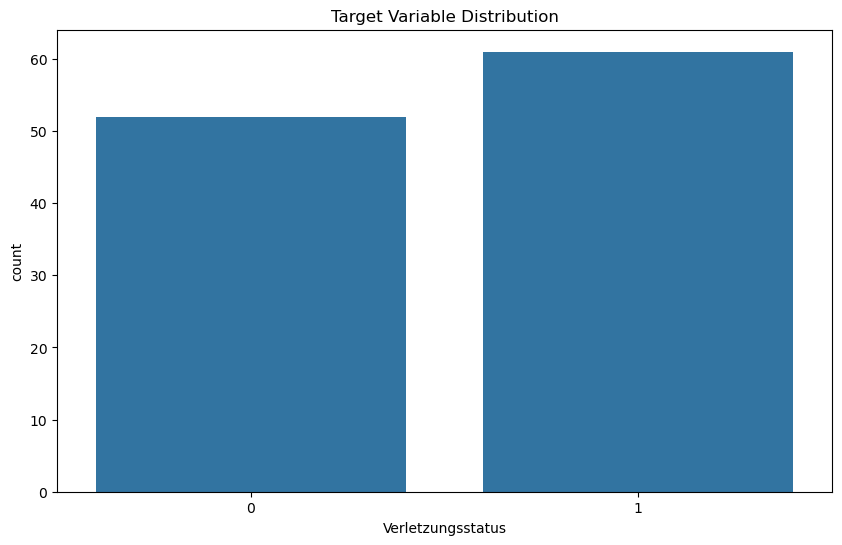

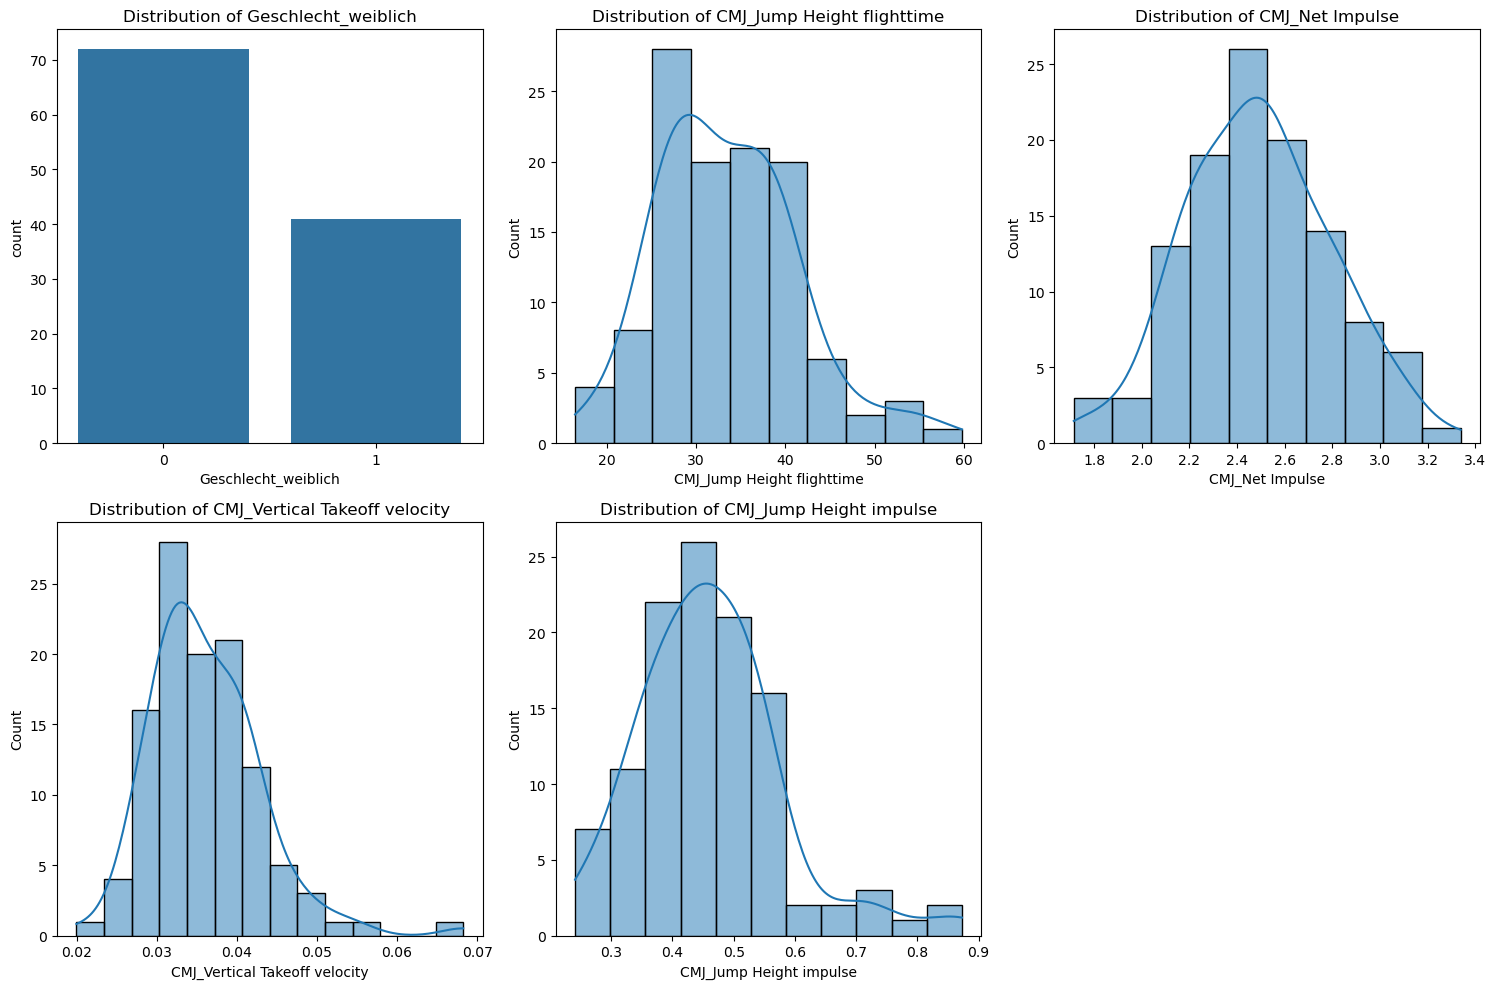


Defining models with parallel processing...


Overall Progress:   0%|          | 0/700 [00:00<?, ?it/s]


Validating model: Logistic Regression


Overall Progress:   7%|▋         | 50/700 [00:23<05:08,  2.10it/s]


Validating model: Decision Tree


Overall Progress:  14%|█▍        | 100/700 [00:34<03:13,  3.10it/s]


Validating model: Random Forest


Overall Progress:  21%|██▏       | 150/700 [00:48<02:44,  3.35it/s]


Validating model: Gradient Boosting


Overall Progress:  29%|██▊       | 200/700 [01:10<03:00,  2.77it/s]


Validating model: XGBoost


Overall Progress:  36%|███▌      | 250/700 [01:24<02:29,  3.02it/s]


Validating model: LightGBM


Overall Progress:  43%|████▎     | 300/700 [02:04<03:14,  2.05it/s]


Validating model: SVC


Overall Progress:  50%|█████     | 350/700 [02:16<02:22,  2.45it/s]


Validating model: k-Nearest Neighbors


Overall Progress:  57%|█████▋    | 400/700 [02:34<01:57,  2.55it/s]


Validating model: MLP Classifier


Overall Progress:  64%|██████▍   | 450/700 [02:51<01:33,  2.67it/s]


Validating model: Gaussian Naive Bayes


Overall Progress:  71%|███████▏  | 500/700 [03:02<01:05,  3.08it/s]


Validating model: Linear Discriminant Analysis


Overall Progress:  79%|███████▊  | 550/700 [03:12<00:43,  3.42it/s]


Validating model: Quadratic Discriminant Analysis


Overall Progress:  86%|████████▌ | 600/700 [03:24<00:27,  3.67it/s]


Validating model: Bagging Classifier


Overall Progress:  93%|█████████▎| 650/700 [03:37<00:13,  3.71it/s]


Validating model: Extra Trees


Overall Progress: 100%|██████████| 700/700 [03:49<00:00,  3.05it/s]


Model Performance Summary:
                              Model   Train Accuracy    Test Accuracy         F1-Score           Recall          ROC-AUC
0               Logistic Regression  0.9998 ± 0.0005  0.8834 ± 0.0689  0.8856 ± 0.0738  0.8635 ± 0.1182  0.9562 ± 0.0438
8                    MLP Classifier  1.0000 ± 0.0000  0.8903 ± 0.0629  0.8958 ± 0.0663  0.8932 ± 0.1005  0.9554 ± 0.0402
4                           XGBoost  1.0000 ± 0.0000  0.8609 ± 0.0555  0.8707 ± 0.0522  0.8758 ± 0.0936  0.9489 ± 0.0341
13                      Extra Trees  1.0000 ± 0.0000  0.8426 ± 0.0768  0.8546 ± 0.0759  0.8677 ± 0.1069  0.9450 ± 0.0450
5                          LightGBM  1.0000 ± 0.0000  0.8708 ± 0.0677  0.8791 ± 0.0674  0.8806 ± 0.0955  0.9450 ± 0.0405
6                               SVC  0.9995 ± 0.0009  0.8679 ± 0.0662  0.8790 ± 0.0605  0.8883 ± 0.0830  0.9441 ± 0.0387
3                 Gradient Boosting  1.0000 ± 0.0000  0.8582 ± 0.0651  0.8687 ± 0.0617  0.8721 ± 0.0886  0.9429 ± 0.0350
10  

In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import time
import warnings
from joblib import Parallel, delayed
from functools import partial

pd.set_option("display.width", 200)
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output


#############################################
# HELPER FUNCTIONS FOR VISUALIZATION
#############################################

def plot_distribution_comparison(X_original, X_augmented, cols_to_plot=None, n_cols=3, figsize=(18, 15)):
    """
    Plot distribution comparison between original and augmented data.

    Parameters:
    -----------
    X_original : DataFrame
        Original feature dataframe
    X_augmented : DataFrame
        Augmented feature dataframe
    cols_to_plot : list, optional
        List of columns to plot. If None, all columns will be plotted.
    n_cols : int, optional
        Number of columns in the subplot grid
    figsize : tuple, optional
        Figure size
    """
    if cols_to_plot is None:
        cols_to_plot = X_original.columns

    n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, col in enumerate(cols_to_plot):
        ax = axes[i]
        if col == "Geschlecht_weiblich":
            # For categorical features like gender, use countplot
            counts_orig = X_original[col].value_counts().reset_index()
            counts_orig.columns = [col, 'count']
            counts_orig['Source'] = 'Original'

            counts_aug = X_augmented[col].value_counts().reset_index()
            counts_aug.columns = [col, 'count']
            counts_aug['Source'] = 'Augmented'

            counts = pd.concat([counts_orig, counts_aug], ignore_index=True)

            sns.barplot(x=col, y='count', hue='Source', data=counts, ax=ax)
            ax.set_xlabel('Gender (Female=1)')
        else:
            # For continuous features, use KDE plots
            if X_original[col].nunique() > 1:  # Nur plotten, wenn mehr als 1 Wert vorhanden
                sns.kdeplot(X_original[col], label='Original', ax=ax, color='blue', fill=True)
            if X_augmented[col].nunique() > 1:  # Nur plotten, wenn mehr als 1 Wert vorhanden
                sns.kdeplot(X_augmented[col], label='Augmented', ax=ax, color='red', fill=True)

        ax.set_title(f'Distribution of {col}')
        ax.legend()

    # Hide empty subplots
    for i in range(len(cols_to_plot), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    return fig


#############################################
# AUGMENTATIONSMETHODEN
#############################################

### 1. Cluster-basierte Augmentation (ohne zusätzliches Rauschen)
def perform_clustering(X_sub, max_clusters=4):
    # Wähle alle numerischen Spalten außer den Gruppierungsvariablen
    cols = [col for col in X_sub.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]
    X_num = X_sub[cols]
    # Berechne die (absoluten) Korrelationen und transformiere in Distanzen
    corr = X_num.corr().abs()
    dist = np.clip(1 - corr, a_min=0, a_max=None)
    dists = squareform(dist.values)
    Z = linkage(dists, method='ward')
    cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
    clusters = {}
    for col, label in zip(cols, cluster_labels):
        clusters.setdefault(label, []).append(col)
    return clusters

def augment_subgroup(X_sub, clusters, p_augment=0.7):
    # Für jede Cluster-Gruppe: berechne Mittelwert und Kovarianzmatrix
    augmented_rows = []
    cluster_params = {}
    for cl_id, cols in clusters.items():
        cluster_data = X_sub[cols]
        mu = cluster_data.mean().values
        if len(cols) == 1:
            cov = np.cov(cluster_data.values.flatten(), ddof=0)
            cov = np.atleast_2d(cov)
        else:
            cov = np.cov(cluster_data.values, rowvar=False)
        cluster_params[cl_id] = (mu, cov, cols)
    # Für jede Zeile werden für jede Cluster-Gruppe (stochastisch) neue Werte gezogen
    for idx, row in X_sub.iterrows():
        new_row = row.copy()
        for cl_id, (mu, cov, cols) in cluster_params.items():
            if np.random.rand() < p_augment:
                new_values = np.random.multivariate_normal(mu, cov)
                for col, val in zip(cols, new_values):
                    new_row[col] = val
        augmented_rows.append(new_row)
    augmented_df = pd.DataFrame(augmented_rows)
    for col in ["Geschlecht_weiblich", "Verletzungsstatus"]:
        if col in augmented_df.columns:
            augmented_df[col] = augmented_df[col].astype(int)
    return augmented_df

# Parallel processing for augmenting one group
def process_group_cluster(group_df, num_new_samples, max_clusters, p_augment):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment=p_augment)
        aug_list.append(aug)
    aug_group = pd.concat(aug_list, axis=0)
    return aug_group

def augment_training_data_cluster(X_train, y_train, num_new_samples=1, max_clusters=4, p_augment=0.7, n_jobs=-1):
    """
    Augmentiert die Trainingsdaten nach dem Cluster-Ansatz mit paralleler Verarbeitung.
    num_new_samples gibt an, wie viele augmentierte Samples pro Originalzeile generiert werden.
    """
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    
    # Prepare groups for parallel processing
    groups = []
    for key, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"]):
        groups.append(group_df)
    
    # Process groups in parallel
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster)(
            group_df, num_new_samples, max_clusters, p_augment
        ) for group_df in groups
    )
        
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug


### 2. Cluster-basierte Augmentation mit Rauschen
def add_noise_to_data(df, noise_factor=0.1):
    df_noisy = df.copy()
    numeric_cols = [col for col in df_noisy.select_dtypes(include=['float64', 'int64']).columns 
                    if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    for col in numeric_cols:
        std = df_noisy[col].std()
        noise = np.random.normal(0, std * noise_factor, size=df_noisy.shape[0])
        df_noisy[col] += noise
    return df_noisy

def add_noise_to_group(df_group, noise_factor=0.1):
    # Hier wird einfach die oben definierte Funktion genutzt
    return add_noise_to_data(df_group, noise_factor=noise_factor)

# Parallel processing for cluster with noise
def process_group_cluster_noise(group_df, num_new_samples, max_clusters, p_augment, noise_factor):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment=p_augment)
        aug_list.append(aug)
    aug_group = pd.concat(aug_list, axis=0).reset_index(drop=True)
    
    # Wende Rauschen an: teile die augmentierten Daten in zwei Hälften
    n = len(aug_group)
    half = n // 2
    global_noise = add_noise_to_data(aug_group.copy(), noise_factor=noise_factor)
    group_noise = add_noise_to_group(aug_group.copy(), noise_factor=noise_factor)
    # Nehme jeweils die erste Hälfte (bei ungerader Anzahl wird der Rest ignoriert)
    aug_noisy = pd.concat([global_noise.iloc[:half], group_noise.iloc[:half]], axis=0)
    return aug_noisy

def augment_training_data_cluster_noise(X_train, y_train, num_new_samples=1, max_clusters=4, p_augment=0.7, noise_factor=0.1, n_jobs=-1):
    """
    Wie augment_training_data_cluster, jedoch wird auf den erzeugten augmentierten Samples
    zusätzlich Rauschen angehängt – zur Hälfte global und zur Hälfte gruppenspezifisch.
    Parallele Verarbeitung mit n_jobs.
    """
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    
    # Prepare groups for parallel processing
    groups = []
    for key, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"]):
        groups.append(group_df)
    
    # Process groups in parallel
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster_noise)(
            group_df, num_new_samples, max_clusters, p_augment, noise_factor
        ) for group_df in groups
    )
        
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug


### 3. Augmentation über Mittelwert-Bildung (Gruppenmittelwerte)

# Function to process a single group with mean-based augmentation
def process_group_means(group_df, group_new_samples):
    group_df = group_df.reset_index(drop=True)
    new_group_samples = []
    for _ in range(group_new_samples):
        sample_indices = np.random.choice(len(group_df), 2, replace=False)
        sample1 = group_df.iloc[sample_indices[0]]
        sample2 = group_df.iloc[sample_indices[1]]
        mean_sample = sample1.copy()
        numeric_cols = [col for col in group_df.columns if col != "Geschlecht_weiblich"]
        for col in numeric_cols:
            mean_sample[col] = (sample1[col] + sample2[col]) / 2
        new_group_samples.append(mean_sample)
    if new_group_samples:
        return pd.DataFrame(new_group_samples)
    return None

def augment_data_by_group_means(X_train, y_train, augmentation_factor=2, n_jobs=-1):
    """
    Augmentiert Daten basierend auf Gruppenmittelwerten mit paralleler Verarbeitung.
    Die Augmentation erfolgt innerhalb der Gruppen, die durch 'Verletzungsstatus'
    und 'Geschlecht_weiblich' definiert sind.
    """
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])
    total_original_samples = len(df_train)
    total_new_samples = int(total_original_samples * (augmentation_factor - 1))
    group_sizes = groups.size()
    group_proportions = group_sizes / total_original_samples
    
    # Prepare tasks for parallel processing
    tasks = []
    for (injury_status, is_female), group_df in groups:
        group_new_samples = int(total_new_samples * group_proportions[(injury_status, is_female)])
        tasks.append((group_df, group_new_samples))
    
    # Process groups in parallel
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_means)(group_df, group_new_samples) 
        for group_df, group_new_samples in tasks
    )
    
    # Filter out None results
    augmented_groups = [group for group in augmented_groups if group is not None]
    
    augmented_df = pd.concat([df_train] + augmented_groups, ignore_index=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug


def augment_training_data_combined(X_train, y_train, target_size=1000, visualize=False, max_plots=10, verbose=True, n_jobs=-1):
    """
    Augment training data with parallel processing
    """
    start_time = time.time()
    
    N = len(X_train)
    additional_needed = max(target_size - N, 0)
    per_method_needed = additional_needed // 3

    num_new_samples = max(per_method_needed // N, 1)
    augmentation_factor = 1 + (per_method_needed / N)

    # Remove the print statements if verbose is False
    if verbose:
        print(f"Starting combined augmentation to reach target size: {target_size}")
        print(f"Original dataset size: {N}")
        print(f"Samples needed per method: {per_method_needed}")
    
    # Parallel execution of all three augmentation methods
    results = Parallel(n_jobs=min(3, n_jobs))(
        delayed(func)(X_train, y_train, **params) for func, params in [
            (augment_training_data_cluster, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
            (augment_training_data_cluster_noise, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
            (augment_data_by_group_means, {"augmentation_factor": augmentation_factor, "n_jobs": n_jobs})
        ]
    )
    
    X_aug_cluster, y_aug_cluster = results[0]
    X_aug_cluster_noise, y_aug_cluster_noise = results[1] 
    X_aug_group_means, y_aug_group_means = results[2]
    
    def subsample(X_aug, y_aug, required):
        if len(X_aug) > required:
            idx = np.random.choice(len(X_aug), required, replace=False)
            return X_aug.iloc[idx].reset_index(drop=True), y_aug.iloc[idx].reset_index(drop=True)
        else:
            return X_aug, y_aug

    X_aug_cluster, y_aug_cluster = subsample(X_aug_cluster, y_aug_cluster, per_method_needed)
    X_aug_cluster_noise, y_aug_cluster_noise = subsample(X_aug_cluster_noise, y_aug_cluster_noise, per_method_needed)
    X_aug_group_means, y_aug_group_means = subsample(X_aug_group_means, y_aug_group_means, per_method_needed)

    X_aug_combined = pd.concat([X_aug_cluster, X_aug_cluster_noise, X_aug_group_means], axis=0).reset_index(drop=True)
    y_aug_combined = pd.concat([y_aug_cluster, y_aug_cluster_noise, y_aug_group_means], axis=0).reset_index(drop=True)

    X_total = pd.concat([X_train.reset_index(drop=True), X_aug_combined], axis=0).reset_index(drop=True)
    y_total = pd.concat([y_train.reset_index(drop=True), y_aug_combined], axis=0).reset_index(drop=True)

    if len(X_total) > target_size:
        idx = np.random.choice(len(X_total), target_size, replace=False)
        X_total = X_total.iloc[idx].reset_index(drop=True)
        y_total = y_total.iloc[idx].reset_index(drop=True)

    elapsed_time = time.time() - start_time
    
    # Remove these print statements if verbose is False
    if verbose:
        print(f"Augmentation completed. Final dataset size: {len(X_total)}")
        print(f"Augmentation took {elapsed_time:.2f} seconds")
    
    if visualize:
        if verbose:
            print("Visualizing distributions of original vs augmented data...")
        cols_to_plot = list(X_train.columns)[:max_plots]
        plot_distribution_comparison(X_train, X_aug_combined, cols_to_plot)
        plt.suptitle('Feature Distributions: Original vs Augmented Data', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.subplot(1, 2, 1)
        sns.countplot(x=y_train)
        plt.title('Original Target Distribution')
        plt.xlabel('Verletzungsstatus')
        
        plt.subplot(1, 2, 2)
        sns.countplot(x=y_total)
        plt.title('Augmented Target Distribution')
        plt.xlabel('Verletzungsstatus')
        
        plt.tight_layout()
        plt.show()

    return X_total, y_total


#############################################
# MODELLVERGLEICH (REPEATED STRATIFIED CV)
#############################################

# Function to process a single fold
def process_fold(fold_idx, train_index, test_index, X, y, model, use_augmentation, target_size, visualize_first_fold):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_df = pd.DataFrame(X_train)
    X_test_df = pd.DataFrame(X_test)
    
    feature_cols = [f"F{i}" for i in range(X_train_df.shape[1])]
    
    gender_col_name = None
    gender_col_idx = None
    
    try:
        if isinstance(X, pd.DataFrame) and "Geschlecht_weiblich" in X.columns:
            gender_col_idx = list(X.columns).index("Geschlecht_weiblich")
            feature_cols[gender_col_idx] = "Geschlecht_weiblich"
            gender_col_name = "Geschlecht_weiblich"
    except:
        pass

    X_train_df.columns = feature_cols
    X_test_df.columns = feature_cols

    cols_to_scale = feature_cols
    if gender_col_name:
        cols_to_scale = [col for col in feature_cols if col != gender_col_name]
        
    scaler = StandardScaler()
    X_train_df[cols_to_scale] = scaler.fit_transform(X_train_df[cols_to_scale])
    X_test_df[cols_to_scale] = scaler.transform(X_test_df[cols_to_scale])

    if use_augmentation:
        visualize_this_fold = visualize_first_fold and fold_idx == 0
        X_train_aug, y_train_aug = augment_training_data_combined(
            X_train_df, pd.Series(y_train), 
            target_size=target_size,
            visualize=visualize_this_fold,
            verbose=False,
            n_jobs=-1  # Use parallel processing here too
        )
    else:
        X_train_aug, y_train_aug = X_train_df, pd.Series(y_train)

    model.fit(X_train_aug, y_train_aug)
    y_train_pred = model.predict(X_train_aug)
    y_test_pred = model.predict(X_test_df)

    accuracy_train = accuracy_score(y_train_aug, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_val = f1_score(y_test, y_test_pred)
    recall_val = recall_score(y_test, y_test_pred)
    
    try:
        roc_auc_val = roc_auc_score(y_test, model.predict_proba(X_test_df)[:, 1])
    except:
        roc_auc_val = np.nan

    return accuracy_train, accuracy_test, f1_val, recall_val, roc_auc_val


def repeated_k_fold(model, X, y, n_splits=5, n_repeats=10, use_augmentation=False, target_size=1000, visualize_first_fold=False, progress_bar=None, n_jobs=-1):
    """
    Perform repeated k-fold cross-validation with parallel processing
    """
    rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    
    # Create a list of fold parameters
    fold_params = []
    for fold_idx, (train_index, test_index) in enumerate(rkf.split(X, y)):
        fold_params.append((fold_idx, train_index, test_index))
    
    # Process folds in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_fold)(
            fold_idx, train_index, test_index, X, y, model, 
            use_augmentation, target_size, visualize_first_fold
        ) for fold_idx, train_index, test_index in fold_params
    )
    
    # Extract metrics from results
    accuracy_train = [r[0] for r in results]
    accuracy_test = [r[1] for r in results]
    f1 = [r[2] for r in results]
    recall = [r[3] for r in results]
    roc_auc = [r[4] for r in results]
    
    # Update the global progress bar if provided
    if progress_bar is not None:
        progress_bar.update(len(fold_params))

    return {
        "Train Accuracy": (np.mean(accuracy_train), np.std(accuracy_train)),
        "Test Accuracy": (np.mean(accuracy_test), np.std(accuracy_test)),
        "F1-Score": (np.mean(f1), np.std(f1)),
        "Recall": (np.mean(recall), np.std(recall)),
        "ROC-AUC": (np.nanmean(roc_auc), np.nanstd(roc_auc)),
    }


#############################################
# HAUPT-EXECUTION: MODELLE VERGLEICHEN
#############################################
if __name__ == '__main__':
    # ---------------------------------------------
    # 1. Datensatz laden
    # ---------------------------------------------
    file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML_neu.xlsx"
    
    try:
        print(f"Loading dataset from {file_path}...")
        df = pd.read_excel(file_path)
        print(f"Dataset loaded. Shape: {df.shape}")

        # ---------------------------------------------
        # 2. Zielvariable und Feature-Matrix erstellen
        # ---------------------------------------------
        y = df['Verletzungsstatus']
        
        # Prüfen, ob "Geschlecht_weiblich" existiert
        if 'Geschlecht_weiblich' in df.columns:
            print("Gender column 'Geschlecht_weiblich' found in dataset.")
            X_df = df.drop(columns=['Verletzungsstatus'])  # Alles außer Zielvariable
        else:
            print("No gender column found in dataset.")
            X_df = df.drop(columns=['Verletzungsstatus'])  # Alles außer Zielvariable

        print("\nData Overview:")
        print(f"Total samples: {len(df)}")
        print(f"Features: {X_df.shape[1]}")
        print(f"Target distribution:\n{y.value_counts()}")

        # ---------------------------------------------
        # 3. Erste Visualisierung der Daten
        # ---------------------------------------------
        # print("\nVisualizing original data distributions...")
        # plt.figure(figsize=(10, 6))
        # sns.countplot(x=y)
        # plt.title('Target Variable Distribution')
        # plt.show()

        # # Beispielhafte Feature-Visualisierung
        # num_features_to_show = min(5, X_df.shape[1])
        # cols_to_plot = X_df.columns[:num_features_to_show]
        
        # plt.figure(figsize=(15, 10))
        # for i, col in enumerate(cols_to_plot):
        #     plt.subplot(2, 3, i + 1)
        #     if X_df[col].nunique() < 10:  # Für kategorische Spalten
        #         sns.countplot(x=X_df[col])
        #     else:
        #         sns.histplot(X_df[col], kde=True)
        #     plt.title(f'Distribution of {col}')
        # plt.tight_layout()
        # plt.show()

        # ---------------------------------------------
        # 4. Modelle definieren mit n_jobs=-1 für parallele Verarbeitung
        # ---------------------------------------------
        print("\nDefining models with parallel processing...")
        models = {
            "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
            "Decision Tree": DecisionTreeClassifier(random_state=42),
            "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
            "Gradient Boosting": GradientBoostingClassifier(random_state=42),
            "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1),
            "LightGBM": LGBMClassifier(verbose=-1, random_state=42, n_jobs=-1),
            "SVC": SVC(probability=True, random_state=42),
            "k-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),
            "MLP Classifier": MLPClassifier(max_iter=1000, random_state=42),
            "Gaussian Naive Bayes": GaussianNB(),
            "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
            "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
            "Bagging Classifier": BaggingClassifier(random_state=42, n_jobs=-1),
            "Extra Trees": ExtraTreesClassifier(random_state=42, n_jobs=-1),
        }

        # ---------------------------------------------
        # 5. Augmentationseinstellungen
        # ---------------------------------------------
        use_augmentation = True
        target_size = 1000
        visualize_first_fold = True
        
        # ---------------------------------------------
        # 6. Cross-Validation & Modellvergleich
        # ---------------------------------------------
        results = []
        
        # Definiere die Werte für n_splits und n_repeats
        n_splits = 5
        n_repeats = 10
        
        # Berechne die Gesamtzahl der Iterationen für den Fortschrittsbalken
        total_iterations = len(models) * n_splits * n_repeats
        
        # Globaler Fortschrittsbalken
        with tqdm(total=total_iterations, desc="Overall Progress") as global_progress:
            for model_name, model in models.items():
                # Nur das Modell ausgeben
                print(f"\nValidating model: {model_name}")

                # Übergebe den Fortschrittsbalken an die Funktion
                metrics = repeated_k_fold(
                    model, X_df, y,
                    n_splits=n_splits,  # explizit übergeben
                    n_repeats=n_repeats,  # explizit übergeben
                    use_augmentation=use_augmentation,
                    target_size=target_size,
                    visualize_first_fold=(visualize_first_fold and model_name == list(models.keys())[0]),
                    progress_bar=global_progress  # Fortschrittsbalken übergeben
                )

                # Ergebnisse formatieren
                formatted_metrics = {
                    "Model": model_name,
                    "Train Accuracy": f"{metrics['Train Accuracy'][0]:.4f} ± {metrics['Train Accuracy'][1]:.4f}",
                    "Test Accuracy": f"{metrics['Test Accuracy'][0]:.4f} ± {metrics['Test Accuracy'][1]:.4f}",
                    "F1-Score": f"{metrics['F1-Score'][0]:.4f} ± {metrics['F1-Score'][1]:.4f}",
                    "Recall": f"{metrics['Recall'][0]:.4f} ± {metrics['Recall'][1]:.4f}",
                    "ROC-AUC": f"{metrics['ROC-AUC'][0]:.4f} ± {metrics['ROC-AUC'][1]:.4f}",
                }

                results.append(formatted_metrics)

        # ---------------------------------------------
        # 7. Ergebnisübersicht
        # ---------------------------------------------
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values(by="ROC-AUC", ascending=False)
        print("\nModel Performance Summary:")
        print(results_df)

    except FileNotFoundError:
        print("Die Datei wurde nicht gefunden. Bitte überprüfe den Pfad.")
    except Exception as e:
        print(f"Ein Fehler ist aufgetreten: {e}")

       

In [ ]:
Modellvergleich mit Min-Max-Normalisierung

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import time
import warnings
from joblib import Parallel, delayed
from functools import partial

pd.set_option("display.width", 200)
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output


#############################################
# HELPER FUNCTIONS FOR VISUALIZATION
#############################################

def plot_distribution_comparison(X_original, X_augmented, cols_to_plot=None, n_cols=3, figsize=(18, 15)):
    """
    Plot distribution comparison between original and augmented data.

    Parameters:
    -----------
    X_original : DataFrame
        Original feature dataframe
    X_augmented : DataFrame
        Augmented feature dataframe
    cols_to_plot : list, optional
        List of columns to plot. If None, all columns will be plotted.
    n_cols : int, optional
        Number of columns in the subplot grid
    figsize : tuple, optional
        Figure size
    """
    if cols_to_plot is None:
        cols_to_plot = X_original.columns

    n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, col in enumerate(cols_to_plot):
        ax = axes[i]
        if col == "Geschlecht_weiblich":
            # For categorical features like gender, use countplot
            counts_orig = X_original[col].value_counts().reset_index()
            counts_orig.columns = [col, 'count']
            counts_orig['Source'] = 'Original'

            counts_aug = X_augmented[col].value_counts().reset_index()
            counts_aug.columns = [col, 'count']
            counts_aug['Source'] = 'Augmented'

            counts = pd.concat([counts_orig, counts_aug], ignore_index=True)

            sns.barplot(x=col, y='count', hue='Source', data=counts, ax=ax)
            ax.set_xlabel('Gender (Female=1)')
        else:
            # For continuous features, use KDE plots
            if X_original[col].nunique() > 1:  # Nur plotten, wenn mehr als 1 Wert vorhanden
                sns.kdeplot(X_original[col], label='Original', ax=ax, color='blue', fill=True)
            if X_augmented[col].nunique() > 1:  # Nur plotten, wenn mehr als 1 Wert vorhanden
                sns.kdeplot(X_augmented[col], label='Augmented', ax=ax, color='red', fill=True)

        ax.set_title(f'Distribution of {col}')
        ax.legend()

    # Hide empty subplots
    for i in range(len(cols_to_plot), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    return fig


#############################################
# AUGMENTATIONSMETHODEN
#############################################

### 1. Cluster-basierte Augmentation (ohne zusätzliches Rauschen)
def perform_clustering(X_sub, max_clusters=4):
    # Wähle alle numerischen Spalten außer den Gruppierungsvariablen
    cols = [col for col in X_sub.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]
    X_num = X_sub[cols]
    # Berechne die (absoluten) Korrelationen und transformiere in Distanzen
    corr = X_num.corr().abs()
    dist = np.clip(1 - corr, a_min=0, a_max=None)
    dists = squareform(dist.values)
    Z = linkage(dists, method='ward')
    cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
    clusters = {}
    for col, label in zip(cols, cluster_labels):
        clusters.setdefault(label, []).append(col)
    return clusters

def augment_subgroup(X_sub, clusters, p_augment=0.7):
    # Für jede Cluster-Gruppe: berechne Mittelwert und Kovarianzmatrix
    augmented_rows = []
    cluster_params = {}
    for cl_id, cols in clusters.items():
        cluster_data = X_sub[cols]
        mu = cluster_data.mean().values
        if len(cols) == 1:
            cov = np.cov(cluster_data.values.flatten(), ddof=0)
            cov = np.atleast_2d(cov)
        else:
            cov = np.cov(cluster_data.values, rowvar=False)
        cluster_params[cl_id] = (mu, cov, cols)
    # Für jede Zeile werden für jede Cluster-Gruppe (stochastisch) neue Werte gezogen
    for idx, row in X_sub.iterrows():
        new_row = row.copy()
        for cl_id, (mu, cov, cols) in cluster_params.items():
            if np.random.rand() < p_augment:
                new_values = np.random.multivariate_normal(mu, cov)
                for col, val in zip(cols, new_values):
                    new_row[col] = val
        augmented_rows.append(new_row)
    augmented_df = pd.DataFrame(augmented_rows)
    for col in ["Geschlecht_weiblich", "Verletzungsstatus"]:
        if col in augmented_df.columns:
            augmented_df[col] = augmented_df[col].astype(int)
    return augmented_df

# Parallel processing for augmenting one group
def process_group_cluster(group_df, num_new_samples, max_clusters, p_augment):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment=p_augment)
        aug_list.append(aug)
    aug_group = pd.concat(aug_list, axis=0)
    return aug_group

def augment_training_data_cluster(X_train, y_train, num_new_samples=1, max_clusters=4, p_augment=0.7, n_jobs=-1):
    """
    Augmentiert die Trainingsdaten nach dem Cluster-Ansatz mit paralleler Verarbeitung.
    num_new_samples gibt an, wie viele augmentierte Samples pro Originalzeile generiert werden.
    """
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    
    # Prepare groups for parallel processing
    groups = []
    for key, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"]):
        groups.append(group_df)
    
    # Process groups in parallel
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster)(
            group_df, num_new_samples, max_clusters, p_augment
        ) for group_df in groups
    )
        
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug


### 2. Cluster-basierte Augmentation mit Rauschen
def add_noise_to_data(df, noise_factor=0.1):
    df_noisy = df.copy()
    numeric_cols = [col for col in df_noisy.select_dtypes(include=['float64', 'int64']).columns 
                    if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    for col in numeric_cols:
        std = df_noisy[col].std()
        noise = np.random.normal(0, std * noise_factor, size=df_noisy.shape[0])
        df_noisy[col] += noise
    return df_noisy

def add_noise_to_group(df_group, noise_factor=0.1):
    # Hier wird einfach die oben definierte Funktion genutzt
    return add_noise_to_data(df_group, noise_factor=noise_factor)

# Parallel processing for cluster with noise
def process_group_cluster_noise(group_df, num_new_samples, max_clusters, p_augment, noise_factor):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment=p_augment)
        aug_list.append(aug)
    aug_group = pd.concat(aug_list, axis=0).reset_index(drop=True)
    
    # Wende Rauschen an: teile die augmentierten Daten in zwei Hälften
    n = len(aug_group)
    half = n // 2
    global_noise = add_noise_to_data(aug_group.copy(), noise_factor=noise_factor)
    group_noise = add_noise_to_group(aug_group.copy(), noise_factor=noise_factor)
    # Nehme jeweils die erste Hälfte (bei ungerader Anzahl wird der Rest ignoriert)
    aug_noisy = pd.concat([global_noise.iloc[:half], group_noise.iloc[:half]], axis=0)
    return aug_noisy

def augment_training_data_cluster_noise(X_train, y_train, num_new_samples=1, max_clusters=4, p_augment=0.7, noise_factor=0.1, n_jobs=-1):
    """
    Wie augment_training_data_cluster, jedoch wird auf den erzeugten augmentierten Samples
    zusätzlich Rauschen angehängt – zur Hälfte global und zur Hälfte gruppenspezifisch.
    Parallele Verarbeitung mit n_jobs.
    """
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    
    # Prepare groups for parallel processing
    groups = []
    for key, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"]):
        groups.append(group_df)
    
    # Process groups in parallel
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster_noise)(
            group_df, num_new_samples, max_clusters, p_augment, noise_factor
        ) for group_df in groups
    )
        
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug


### 3. Augmentation über Mittelwert-Bildung (Gruppenmittelwerte)

# Function to process a single group with mean-based augmentation
def process_group_means(group_df, group_new_samples):
    group_df = group_df.reset_index(drop=True)
    new_group_samples = []
    for _ in range(group_new_samples):
        sample_indices = np.random.choice(len(group_df), 2, replace=False)
        sample1 = group_df.iloc[sample_indices[0]]
        sample2 = group_df.iloc[sample_indices[1]]
        mean_sample = sample1.copy()
        numeric_cols = [col for col in group_df.columns if col != "Geschlecht_weiblich"]
        for col in numeric_cols:
            mean_sample[col] = (sample1[col] + sample2[col]) / 2
        new_group_samples.append(mean_sample)
    if new_group_samples:
        return pd.DataFrame(new_group_samples)
    return None

def augment_data_by_group_means(X_train, y_train, augmentation_factor=2, n_jobs=-1):
    """
    Augmentiert Daten basierend auf Gruppenmittelwerten mit paralleler Verarbeitung.
    Die Augmentation erfolgt innerhalb der Gruppen, die durch 'Verletzungsstatus'
    und 'Geschlecht_weiblich' definiert sind.
    """
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])
    total_original_samples = len(df_train)
    total_new_samples = int(total_original_samples * (augmentation_factor - 1))
    group_sizes = groups.size()
    group_proportions = group_sizes / total_original_samples
    
    # Prepare tasks for parallel processing
    tasks = []
    for (injury_status, is_female), group_df in groups:
        group_new_samples = int(total_new_samples * group_proportions[(injury_status, is_female)])
        tasks.append((group_df, group_new_samples))
    
    # Process groups in parallel
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_means)(group_df, group_new_samples) 
        for group_df, group_new_samples in tasks
    )
    
    # Filter out None results
    augmented_groups = [group for group in augmented_groups if group is not None]
    
    augmented_df = pd.concat([df_train] + augmented_groups, ignore_index=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug


def augment_training_data_combined(X_train, y_train, target_size=1000, visualize=False, max_plots=10, verbose=True, n_jobs=-1):
    """
    Augment training data with parallel processing
    """
    start_time = time.time()
    
    N = len(X_train)
    additional_needed = max(target_size - N, 0)
    per_method_needed = additional_needed // 3

    num_new_samples = max(per_method_needed // N, 1)
    augmentation_factor = 1 + (per_method_needed / N)

    # Remove the print statements if verbose is False
    if verbose:
        print(f"Starting combined augmentation to reach target size: {target_size}")
        print(f"Original dataset size: {N}")
        print(f"Samples needed per method: {per_method_needed}")
    
    # Parallel execution of all three augmentation methods
    results = Parallel(n_jobs=min(3, n_jobs))(
        delayed(func)(X_train, y_train, **params) for func, params in [
            (augment_training_data_cluster, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
            (augment_training_data_cluster_noise, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
            (augment_data_by_group_means, {"augmentation_factor": augmentation_factor, "n_jobs": n_jobs})
        ]
    )
    
    X_aug_cluster, y_aug_cluster = results[0]
    X_aug_cluster_noise, y_aug_cluster_noise = results[1] 
    X_aug_group_means, y_aug_group_means = results[2]
    
    def subsample(X_aug, y_aug, required):
        if len(X_aug) > required:
            idx = np.random.choice(len(X_aug), required, replace=False)
            return X_aug.iloc[idx].reset_index(drop=True), y_aug.iloc[idx].reset_index(drop=True)
        else:
            return X_aug, y_aug

    X_aug_cluster, y_aug_cluster = subsample(X_aug_cluster, y_aug_cluster, per_method_needed)
    X_aug_cluster_noise, y_aug_cluster_noise = subsample(X_aug_cluster_noise, y_aug_cluster_noise, per_method_needed)
    X_aug_group_means, y_aug_group_means = subsample(X_aug_group_means, y_aug_group_means, per_method_needed)

    X_aug_combined = pd.concat([X_aug_cluster, X_aug_cluster_noise, X_aug_group_means], axis=0).reset_index(drop=True)
    y_aug_combined = pd.concat([y_aug_cluster, y_aug_cluster_noise, y_aug_group_means], axis=0).reset_index(drop=True)

    X_total = pd.concat([X_train.reset_index(drop=True), X_aug_combined], axis=0).reset_index(drop=True)
    y_total = pd.concat([y_train.reset_index(drop=True), y_aug_combined], axis=0).reset_index(drop=True)

    if len(X_total) > target_size:
        idx = np.random.choice(len(X_total), target_size, replace=False)
        X_total = X_total.iloc[idx].reset_index(drop=True)
        y_total = y_total.iloc[idx].reset_index(drop=True)

    elapsed_time = time.time() - start_time
    
    # Remove these print statements if verbose is False
    if verbose:
        print(f"Augmentation completed. Final dataset size: {len(X_total)}")
        print(f"Augmentation took {elapsed_time:.2f} seconds")
    
    if visualize:
        if verbose:
            print("Visualizing distributions of original vs augmented data...")
        cols_to_plot = list(X_train.columns)[:max_plots]
        plot_distribution_comparison(X_train, X_aug_combined, cols_to_plot)
        plt.suptitle('Feature Distributions: Original vs Augmented Data', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.subplot(1, 2, 1)
        sns.countplot(x=y_train)
        plt.title('Original Target Distribution')
        plt.xlabel('Verletzungsstatus')
        
        plt.subplot(1, 2, 2)
        sns.countplot(x=y_total)
        plt.title('Augmented Target Distribution')
        plt.xlabel('Verletzungsstatus')
        
        plt.tight_layout()
        plt.show()

    return X_total, y_total


#############################################
# MODELLVERGLEICH (REPEATED STRATIFIED CV)
#############################################

# Function to process a single fold
def process_fold(fold_idx, train_index, test_index, X, y, model, use_augmentation, target_size, visualize_first_fold):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_df = pd.DataFrame(X_train)
    X_test_df = pd.DataFrame(X_test)
    
    feature_cols = [f"F{i}" for i in range(X_train_df.shape[1])]
    
    gender_col_name = None
    gender_col_idx = None
    
    try:
        if isinstance(X, pd.DataFrame) and "Geschlecht_weiblich" in X.columns:
            gender_col_idx = list(X.columns).index("Geschlecht_weiblich")
            feature_cols[gender_col_idx] = "Geschlecht_weiblich"
            gender_col_name = "Geschlecht_weiblich"
    except:
        pass

    X_train_df.columns = feature_cols
    X_test_df.columns = feature_cols

    cols_to_scale = feature_cols
    if gender_col_name:
        cols_to_scale = [col for col in feature_cols if col != gender_col_name]
        
    # Änderung hier: Verwende MinMaxScaler statt StandardScaler
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X_train_df[cols_to_scale] = scaler.fit_transform(X_train_df[cols_to_scale])
    X_test_df[cols_to_scale] = scaler.transform(X_test_df[cols_to_scale])

    if use_augmentation:
        visualize_this_fold = visualize_first_fold and fold_idx == 0
        X_train_aug, y_train_aug = augment_training_data_combined(
            X_train_df, pd.Series(y_train), 
            target_size=target_size,
            visualize=visualize_this_fold,
            verbose=False,
            n_jobs=-1  # Use parallel processing here too
        )
    else:
        X_train_aug, y_train_aug = X_train_df, pd.Series(y_train)

    model.fit(X_train_aug, y_train_aug)
    y_train_pred = model.predict(X_train_aug)
    y_test_pred = model.predict(X_test_df)

    accuracy_train = accuracy_score(y_train_aug, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_val = f1_score(y_test, y_test_pred)
    recall_val = recall_score(y_test, y_test_pred)
    
    try:
        roc_auc_val = roc_auc_score(y_test, model.predict_proba(X_test_df)[:, 1])
    except:
        roc_auc_val = np.nan

    return accuracy_train, accuracy_test, f1_val, recall_val, roc_auc_val

def repeated_k_fold(model, X, y, n_splits=5, n_repeats=10, use_augmentation=False, target_size=1000, visualize_first_fold=False, progress_bar=None, n_jobs=-1):
    """
    Perform repeated k-fold cross-validation with parallel processing
    """
    rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    
    # Create a list of fold parameters
    fold_params = []
    for fold_idx, (train_index, test_index) in enumerate(rkf.split(X, y)):
        fold_params.append((fold_idx, train_index, test_index))
    
    # Process folds in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_fold)(
            fold_idx, train_index, test_index, X, y, model, 
            use_augmentation, target_size, visualize_first_fold
        ) for fold_idx, train_index, test_index in fold_params
    )
    
    # Extract metrics from results
    accuracy_train = [r[0] for r in results]
    accuracy_test = [r[1] for r in results]
    f1 = [r[2] for r in results]
    recall = [r[3] for r in results]
    roc_auc = [r[4] for r in results]
    
    # Update the global progress bar if provided
    if progress_bar is not None:
        progress_bar.update(len(fold_params))

    return {
        "Train Accuracy": (np.mean(accuracy_train), np.std(accuracy_train)),
        "Test Accuracy": (np.mean(accuracy_test), np.std(accuracy_test)),
        "F1-Score": (np.mean(f1), np.std(f1)),
        "Recall": (np.mean(recall), np.std(recall)),
        "ROC-AUC": (np.nanmean(roc_auc), np.nanstd(roc_auc)),
    }


#############################################
# HAUPT-EXECUTION: MODELLE VERGLEICHEN
#############################################
if __name__ == '__main__':
    # ---------------------------------------------
    # 1. Datensatz laden
    # ---------------------------------------------
    file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML_neu.xlsx"
    
    try:
        print(f"Loading dataset from {file_path}...")
        df = pd.read_excel(file_path)
        print(f"Dataset loaded. Shape: {df.shape}")

        # ---------------------------------------------
        # 2. Zielvariable und Feature-Matrix erstellen
        # ---------------------------------------------
        y = df['Verletzungsstatus']
        
        # Prüfen, ob "Geschlecht_weiblich" existiert
        if 'Geschlecht_weiblich' in df.columns:
            print("Gender column 'Geschlecht_weiblich' found in dataset.")
            X_df = df.drop(columns=['Verletzungsstatus'])  # Alles außer Zielvariable
        else:
            print("No gender column found in dataset.")
            X_df = df.drop(columns=['Verletzungsstatus'])  # Alles außer Zielvariable

        print("\nData Overview:")
        print(f"Total samples: {len(df)}")
        print(f"Features: {X_df.shape[1]}")
        print(f"Target distribution:\n{y.value_counts()}")

        # ---------------------------------------------
        # 3. Erste Visualisierung der Daten
        # ---------------------------------------------
        # print("\nVisualizing original data distributions...")
        # plt.figure(figsize=(10, 6))
        # sns.countplot(x=y)
        # plt.title('Target Variable Distribution')
        # plt.show()

        # # Beispielhafte Feature-Visualisierung
        # num_features_to_show = min(5, X_df.shape[1])
        # cols_to_plot = X_df.columns[:num_features_to_show]
        
        # plt.figure(figsize=(15, 10))
        # for i, col in enumerate(cols_to_plot):
        #     plt.subplot(2, 3, i + 1)
        #     if X_df[col].nunique() < 10:  # Für kategorische Spalten
        #         sns.countplot(x=X_df[col])
        #     else:
        #         sns.histplot(X_df[col], kde=True)
        #     plt.title(f'Distribution of {col}')
        # plt.tight_layout()
        # plt.show()

        # ---------------------------------------------
        # 4. Modelle definieren mit n_jobs=-1 für parallele Verarbeitung
        # ---------------------------------------------
        print("\nDefining models with parallel processing...")
        models = {
            "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
            "Decision Tree": DecisionTreeClassifier(random_state=42),
            "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
            "Gradient Boosting": GradientBoostingClassifier(random_state=42),
            "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1),
            "LightGBM": LGBMClassifier(verbose=-1, random_state=42, n_jobs=-1),
            "SVC": SVC(probability=True, random_state=42),
            "k-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),
            "MLP Classifier": MLPClassifier(max_iter=1000, random_state=42),
            "Gaussian Naive Bayes": GaussianNB(),
            "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
            "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
            "Bagging Classifier": BaggingClassifier(random_state=42, n_jobs=-1),
            "Extra Trees": ExtraTreesClassifier(random_state=42, n_jobs=-1),
        }

        # ---------------------------------------------
        # 5. Augmentationseinstellungen
        # ---------------------------------------------
        use_augmentation = True
        target_size = 1000
        visualize_first_fold = True
        
        # ---------------------------------------------
        # 6. Cross-Validation & Modellvergleich
        # ---------------------------------------------
        results = []
        
        # Definiere die Werte für n_splits und n_repeats
        n_splits = 5
        n_repeats = 10
        
        # Berechne die Gesamtzahl der Iterationen für den Fortschrittsbalken
        total_iterations = len(models) * n_splits * n_repeats
        
        # Globaler Fortschrittsbalken
        with tqdm(total=total_iterations, desc="Overall Progress") as global_progress:
            for model_name, model in models.items():
                # Nur das Modell ausgeben
                print(f"\nValidating model: {model_name}")

                # Übergebe den Fortschrittsbalken an die Funktion
                metrics = repeated_k_fold(
                    model, X_df, y,
                    n_splits=n_splits,  # explizit übergeben
                    n_repeats=n_repeats,  # explizit übergeben
                    use_augmentation=use_augmentation,
                    target_size=target_size,
                    visualize_first_fold=(visualize_first_fold and model_name == list(models.keys())[0]),
                    progress_bar=global_progress  # Fortschrittsbalken übergeben
                )

                # Ergebnisse formatieren
                formatted_metrics = {
                    "Model": model_name,
                    "Train Accuracy": f"{metrics['Train Accuracy'][0]:.4f} ± {metrics['Train Accuracy'][1]:.4f}",
                    "Test Accuracy": f"{metrics['Test Accuracy'][0]:.4f} ± {metrics['Test Accuracy'][1]:.4f}",
                    "F1-Score": f"{metrics['F1-Score'][0]:.4f} ± {metrics['F1-Score'][1]:.4f}",
                    "Recall": f"{metrics['Recall'][0]:.4f} ± {metrics['Recall'][1]:.4f}",
                    "ROC-AUC": f"{metrics['ROC-AUC'][0]:.4f} ± {metrics['ROC-AUC'][1]:.4f}",
                }

                results.append(formatted_metrics)
                
        # ---------------------------------------------
        # 7. Ergebnisübersicht
        # ---------------------------------------------
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values(by="ROC-AUC", ascending=False)
        print("\nModel Performance Summary:")
        print(results_df)

    except FileNotFoundError:
        print("Die Datei wurde nicht gefunden. Bitte überprüfe den Pfad.")
    except Exception as e:
        print(f"Ein Fehler ist aufgetreten: {e}")

       